In [1]:
import json
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import lxml
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pandas import json_normalize
import matplotlib
import matplotlib.pyplot as plt
import mplsoccer
from mplsoccer import Pitch, VerticalPitch, FontManager
import seaborn as sns
import numpy as np
chrome_driver_path = r"C:\Users\Al Raven\anaconda3\Lib\site-packages\selenium\webdriver\chrome\chromedriver.exe"

# **Specify teams, ids and competition info**

In [2]:
h_team = 'Wolves'
a_team = 'Man Utd'
h_id = 161
a_id = 32
competition_date = 'Premier League - February 1, 2024'

# Scraping & Data Prep

***Just add the link from WhoScored***  
(you might have to close/tick some pop-ups, be sure to do it or it won't work)

In [3]:
#scraping code inspired by Varun Vasudevan (@TheDevilsDNA)
driver = webdriver.Chrome()
df1 = pd.DataFrame()
links = ['https://www.whoscored.com/Matches/1729457/Live/England-Premier-League-2023-2024-Wolves-Manchester-United']

wait = WebDriverWait(driver, 20)  # Increase time if needed

for i in links:    
    driver.get(i)
    
    # Close ad or accept cookies (replace with the actual element)
    try:
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="some-button-id"]')))
        close_button.click()
    except:
        pass
    
    # Wait for the overlay to disappear (if it does so automatically)
    wait.until(EC.invisibility_of_element((By.ID, 'qc-cmp2-ui')))
    
    match_centre = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="sub-navigation"]/ul/li[4]/a')))
    match_centre.click()
    
    element = wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="layout-wrapper"]/script[1]')))
    match_centre = driver.find_element("xpath",'//*[@id="sub-navigation"]/ul/li[4]/a')
    match_centre.click()
    element = driver.find_element("xpath",'//*[@id="layout-wrapper"]/script[1]')
    script_content = element.get_attribute('innerHTML')
    script_ls = script_content.split(sep="  ")
    script_ls = list(filter(None, script_ls))
    script_ls = [name for name in script_ls if name.strip()]
    dictstring = script_ls[2][17:-2]
    content = json.loads(dictstring)
    match = json_normalize(content['events'],sep='_')
    hometeam = content['home']['name']
    awayteam = content['away']['name']
    homeid = content['home']['teamId']
    awayid = content['away']['teamId']
    players = pd.DataFrame()
    homepl = json_normalize(content['home']['players'],sep='_')[['name', 'position', 'shirtNo', 'playerId']]
    awaypl = json_normalize(content['away']['players'],sep='_')[['name', 'position', 'shirtNo', 'playerId']]
    players = pd.concat([homepl,awaypl])
    match = match.merge(players, how='left')
    df1 = pd.concat([df1, match])
    #match_id += 1
    driver.close()

***Here you need to download the WhoScored page as HTML, then add the path to that file in "match_html_path"***

In [4]:
#scraping code and data prep inspired by Karol Działowski: https://www.dzialowski.eu/football-data-visualisations/
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r',encoding="utf8")
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict, players_ids
match_html_path = r"C:\Users\Al Raven\Documents\Football\WhoScored HTML match files\Wolves 3-4 Manchester United - Premier League 2023_2024 Live.htm"
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict, players_ids = extract_data_from_dict(data)

**Data prep**

In [5]:
#passes
df_passes = df1.loc[df1['type_displayName']=='Pass'].copy()
h_passes = df_passes[df_passes['teamId']==h_id]
a_passes = df_passes[df_passes['teamId']==a_id]
#passes IN opponent's half
h_opphalf_passes = h_passes[h_passes['x']>=50]
a_opphalf_passes = a_passes[a_passes['x']>=50]
#completed passes in opponent's half 
h_comp_opphalf_passes = h_opphalf_passes[h_opphalf_passes['outcomeType_displayName']=='Successful']
a_comp_opphalf_passes = a_opphalf_passes[a_opphalf_passes['outcomeType_displayName']=='Successful']
#passes in their own half
h_ownhalf_passes = h_passes[h_passes['x']<50]
a_ownhalf_passes = a_passes[a_passes['x']<50]
#completed passes in own half 
h_comp_ownhalf_passes = h_ownhalf_passes[h_ownhalf_passes['outcomeType_displayName']=='Successful']
a_comp_ownhalf_passes = a_ownhalf_passes[a_ownhalf_passes['outcomeType_displayName']=='Successful']
#passes INTO the final third
h_final_3rd_passes = h_passes[h_passes['endX']>=66]
h_final_3rd_passes = h_final_3rd_passes[h_final_3rd_passes['x']<=66]
a_final_3rd_passes = a_passes[a_passes['endX']>=66]
a_final_3rd_passes = a_final_3rd_passes[a_final_3rd_passes['x']<=66]
#completed passes into the final third
h_comp_final3rd_passes = h_final_3rd_passes[h_final_3rd_passes['outcomeType_displayName']=='Successful']
a_comp_final3rd_passes = a_final_3rd_passes[a_final_3rd_passes['outcomeType_displayName']=='Successful']
#passes into the opponent's box
#h_passes_intobox = h_passes[(h_passes['endX']>=85)&(h_passes['endY']>=20)&(h_passes['endY']<=80)]
h_passes_intobox = h_passes[((h_passes['endX']>=85)&(h_passes['x']<85)&(h_passes['endY']>=20)&(h_passes['endY']<=80))|
                           ((h_passes['endX']>=85)&(h_passes['x']>85)&(h_passes['endY']>=20)&(h_passes['endY']<=80)
                            &(h_passes['y']>80)&(h_passes['y']<20))]
a_passes_intobox = a_passes[((a_passes['endX']>=85)&(a_passes['x']<85)&(a_passes['endY']>=20)&(a_passes['endY']<=80))|
                           ((a_passes['endX']>=85)&(a_passes['x']>85)&(a_passes['endY']>=20)&(a_passes['endY']<=80)
                            &(a_passes['y']>80)&(a_passes['y']<20))]
#completed/successful passes into the opponent's box
h_comp_passes_intobox = h_passes_intobox[h_passes_intobox['outcomeType_displayName']=='Successful']
a_comp_passes_intobox = a_passes_intobox[a_passes_intobox['outcomeType_displayName']=='Successful']

#take-ons/dribbles
df_dribbles = df1.loc[df1['type_displayName']=='TakeOn'].copy()
h_dribbles = df_dribbles[df_dribbles['teamId']==h_id]
a_dribbles = df_dribbles[df_dribbles['teamId']==a_id]
#touches
df_touches = df1.loc[df1['isTouch']==True].copy()
h_touches = df_touches[df_touches['teamId']==h_id]
a_touches = df_touches[df_touches['teamId']==a_id]
df_touches2 = df1.loc[df1['type_displayName']=='BallTouch'].copy()
h_touches2 = df_touches2[df_touches2['teamId']==h_id]
a_touches2 = df_touches2[df_touches2['teamId']==a_id]
#dispossessions
df_dispossessions = df1.loc[df1['type_displayName']=='Dispossessed'].copy()
h_dispossessions = df_dispossessions[df_dispossessions['teamId']==h_id]
a_dispossessions = df_dispossessions[df_dispossessions['teamId']==a_id]
#shots
df_shots = df1.loc[df1['isShot']==True].copy()
h_shots = df_shots[df_shots['teamId']==h_id]
a_shots = df_shots[df_shots['teamId']==a_id]
#goals
df_goals = df1.loc[df1['type_displayName']=='Goal'].copy()
h_goals = df_goals[df_goals['teamId']==h_id]
a_goals = df_goals[df_goals['teamId']==a_id]
#tackles
df_tackles = df1.loc[df1.type_displayName=='Tackle'].copy()
h_tackles = df_tackles[df_tackles['teamId']==h_id]
a_tackles = df_tackles[df_tackles['teamId']==a_id]
#challenges
df_challenges = df1.loc[df1.type_displayName=='Challenge'].copy()
h_challenges = df_challenges[df_challenges['teamId']==h_id]
a_challenges = df_challenges[df_challenges['teamId']==a_id]
#clearances
df_clearances = df1.loc[df1.type_displayName=='Clearance'].copy()
h_clearances = df_clearances[df_clearances['teamId']==h_id]
a_clearances = df_clearances[df_clearances['teamId']==a_id]
#recoveries
df_recoveries = df1.loc[df1.type_displayName=='BallRecovery'].copy()
h_recoveries = df_recoveries[df_recoveries['teamId']==h_id]
a_recoveries = df_recoveries[df_recoveries['teamId']==a_id]
#blocked passes
df_blocked_passes = df1.loc[df1.type_displayName=='BlockedPass'].copy()
h_blocked_passes = df_blocked_passes[df_blocked_passes['teamId']==h_id]
a_blocked_passes = df_blocked_passes[df_blocked_passes['teamId']==a_id]
#blocked shots
df_blocked_shots = df_shots.loc[df_shots['blockedX'].notna()].copy()
h_blocked_shots = df_blocked_shots[df_blocked_shots['teamId']==a_id]
a_blocked_shots = df_blocked_shots[df_blocked_shots['teamId']==h_id]
#interceptions
df_interceptions = df1.loc[df1.type_displayName=='Interception'].copy()
h_interceptions = df_interceptions[df_interceptions['teamId']==h_id]
a_interceptions = df_interceptions[df_interceptions['teamId']==a_id]
#aerial duels
df_aerials = df1.loc[df1['type_displayName']=='Aerial'].copy()
h_aerials = df_aerials[df_aerials['teamId']==h_id]
a_aerials = df_aerials[df_aerials['teamId']==a_id]
#all defensive actions: 
df_defensive_actions = pd.concat([df1.loc[(df1.type_displayName=='Challenge') |  
        (df1.type_displayName=='BlockedPass')|
        (df1.type_displayName=='Tackle')|
        (df1.type_displayName=='Interception')|
        (df1.type_displayName=='Aerial')|
        (df1.type_displayName=='Foul')].copy(),df_blocked_shots])
h_defensive_actions = df_defensive_actions[df_defensive_actions['teamId']==h_id]
a_defensive_actions = df_defensive_actions[df_defensive_actions['teamId']==a_id]



#gk saves
df_saves = df1.loc[df1['type_displayName']=='SavedShot'].copy()
#gk pickups
df_pickups = df1.loc[df1['type_displayName']=='KeeperPickup'].copy()
#gk sweeps
df_sweeps = df1.loc[df1['type_displayName']=='KeeperSweeper']
#gk claims
df_claims = df1.loc[df1['type_displayName']=='Claim'].copy()
#gk punches
df_punches = df1.loc[df1['type_displayName']=='Punch'].copy()
#all gk actions
gk_actions = pd.concat([df_saves, df_pickups, df_sweeps, df_claims, df_punches])

In [6]:
df_passes['beginning'] = np.sqrt(np.square(100 - df_passes['x']) + np.square(50 - df_passes['y']))
df_passes['end'] = np.sqrt(np.square(100 - df_passes['endX']) + np.square(50 - df_passes['endY']))
df_passes.loc[:, 'progressive'] = df_passes['end'] / df_passes['beginning'] < 0.75
df_progressive_passes = df_passes[df_passes['progressive']==True]

In [7]:
a_comp_passes_intobox.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'qualifiers', 'satisfiedEventsTypes', 'isTouch',
       'period_value', 'period_displayName', 'type_value', 'type_displayName',
       'outcomeType_value', 'outcomeType_displayName', 'playerId', 'endX',
       'endY', 'relatedEventId', 'relatedPlayerId', 'cardType_value',
       'cardType_displayName', 'goalMouthZ', 'goalMouthY', 'isGoal', 'isShot',
       'blockedX', 'blockedY', 'name', 'position', 'shirtNo'],
      dtype='object')

In [8]:
a_comp_passes_intobox

id  eventId  minute  second  teamId     x     y  \
66    2.641429e+09       56       4    22.0      32  83.4  13.2   
391   2.641432e+09      240      25    44.0      32  69.4  13.4   
513   2.641434e+09      318      33    30.0      32  76.7  76.0   
939   2.641444e+09      551      54    28.0      32  84.7  16.7   
1489  2.641450e+09      799      93    35.0      32  79.1  11.5   

      expandedMinute                                         qualifiers  \
66                 4  [{'type': {'value': 141, 'displayName': 'PassE...   
391               25  [{'type': {'value': 5, 'displayName': 'Freekic...   
513               33  [{'type': {'value': 141, 'displayName': 'PassE...   
939               59  [{'type': {'value': 20, 'displayName': 'RightF...   
1489              98  [{'type': {'value': 56, 'displayName': 'Zone'}...   

                                   satisfiedEventsTypes  ...  \
66            [91, 119, 117, 30, 205, 36, 37, 217, 218]  ...   
391   [91, 119, 123, 137, 124, 125, 203, 40, 41, 44,...  ...   
513           [91, 119, 117, 30, 205, 36, 37, 217, 218]  ...   
939   [91, 119, 123, 137, 124, 125, 40, 41, 36, 37, ...  ...   
1489          [91, 119, 117, 30, 205, 36, 37, 217, 218]  ...   

      cardType_displayName  goalMouthZ goalMouthY  isGoal isShot  blockedX  \
66                     NaN         NaN        NaN     NaN    NaN       NaN   
391                    NaN         NaN        NaN     NaN    NaN       NaN   
513                    NaN         NaN        NaN     NaN    NaN       NaN   
939                    NaN         NaN        NaN     NaN    NaN       NaN   
1489                   NaN         NaN        NaN     NaN    NaN       NaN   

     blockedY                name  position  shirtNo  
66        NaN         Diogo Dalot        DR     20.0  
391       NaN     Bruno Fernandes       AMC      8.0  
513       NaN     Bruno Fernandes       AMC      8.0  
939       NaN  Alejandro Garnacho       AMR     17.0  
1489      NaN        Omari Forson       Sub     62.0  

[5 rows x 33 columns]

***Creating the Carries and Progressive Carries Data***

In [9]:
def get_events_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    return df
df = get_events_df(events_dict)

In [10]:
#For now I can only create carries and progressive carries dataframmes for one player based on his WhoScored playerId
#Put the player's id here, you can find the list of ids in the players_df below
player_id = 460260

In [11]:
players_df

playerId  shirtNo                    name position  height  weight  age  \
0     122714        1                 José Sá       GK     192      84   31   
1     431283       24                    Toti       DC     187      72   25   
2      73063       15            Craig Dawson       DC     188      82   33   
3     368310       23       Maximilian Kilman       DC     194      89   26   
4     296363       22           Nélson Semedo      DMR     177      69   30   
5      94042        2            Matt Doherty      DML     185      80   32   
6     123481        5            Mario Lemina       MC     184      85   30   
7     386856       20             Tommy Doyle       MC     172      73   22   
8     362758       12           Matheus Cunha      AMC     183      76   24   
9     337916        7              Pedro Neto      AMC     172      62   23   
10    320242       27  Jean-Ricner Bellegarde       FW     170      70   25   
11    355401        3         Rayan Aït-Nouri      Sub     180      70   22   
12    403693        8              João Gomes      Sub     176      74   22   
13     94868       21           Pablo Sarabia      Sub     174      70   31   
14    463235       63           Nathan Fraser      Sub     188      82   18   
15    443578       32               Joe Hodge      Sub     172      65   21   
16    409730       17              Hugo Bueno      Sub     180      73   21   
17    444241        4          Santiago Bueno      Sub     190      76   25   
18    134543       25             Dan Bentley      Sub     188      73   30   
19    437381       62         Tawanda Chirewa      Sub       0       0   20   
0     260843       24             André Onana       GK     190      93   27   
1     353418       20             Diogo Dalot       DR     183      76   24   
2     340105        6       Lisandro Martínez       DC     175      77   26   
3      93206       19          Raphaël Varane       DC     191      81   30   
4     118244       23               Luke Shaw       DL     185      75   28   
5      88526       18                Casemiro      DMC     185      84   31   
6     460260       37           Kobbie Mainoo      DMC     175       0   18   
7     437022       17      Alejandro Garnacho      AMR     180      80   19   
8     123761        8         Bruno Fernandes      AMC     179      69   29   
9     300299       10         Marcus Rashford      AML     180      70   26   
10    439584       11          Rasmus Højlund       FW     191      79   20   
11    364315       21                  Antony      Sub     174      63   23   
12     99487        5           Harry Maguire      Sub     194      90   30   
13    491385       62            Omari Forson      Sub       0       0   19   
14    336915       39         Scott McTominay      Sub     193      88   27   
15     22079       35             Jonny Evans      Sub     188      77   36   
16     69344       14       Christian Eriksen      Sub     182      76   31   
17    494120       53          Willy Kambwala      Sub       0       0   19   
18    361707        1          Altay Bayindir      Sub     198      88   25   
19    386634       16             Amad Diallo      Sub     173      72   21   

   isFirstEleven  isManOfTheMatch field  \
0           True            False  home   
1           True            False  home   
2           True            False  home   
3           True            False  home   
4           True            False  home   
5           True            False  home   
6           True            False  home   
7           True            False  home   
8           True            False  home   
9           True             True  home   
10          True            False  home   
11           NaN            False  home   
12           NaN            False  home   
13           NaN            False  home   
14           NaN            False  home   
15           NaN            False  home   
16           NaN            False

In [12]:
carries = []

for index, event in df.iterrows():
    if event['eventType'] == 'Pass' and event['receiver'] == player_id:
        # The player received the ball
        start_event = event
        carry_ongoing = True
        for subsequent_index in range(index + 1, len(df)):
            subsequent_event = df.iloc[subsequent_index]
            if subsequent_event['playerId'] != player_id:
                continue  # Skip events not involving this player

            # Check if the event ends the carry
            if subsequent_event['playerId'] == player_id:
                # Consider shots and touches as potential carry-ending events
                if subsequent_event['isShot'] or (subsequent_event['eventType'] in ['Pass', 'Goal'] or subsequent_event['Dispossessed']):
                    end_event = subsequent_event
                    carry_ongoing = False
                    break

        if not carry_ongoing:
            # Extract carry data
            carry_data = {
                'start_x': start_event['endX'],  # End position of the pass
                'start_y': start_event['endY'],
                'end_x': end_event['x'],        # Position of the ending event
                'end_y': end_event['y'],
                # Add other details as needed
            }
            carries.append(carry_data)

# Create the carries DataFrame
player_carries = pd.DataFrame(carries)

# Assuming the opponent's goal is at x = 100
goal_x = 100

for index, row in player_carries.iterrows():
    start_distance = np.sqrt(np.square(goal_x - row['start_x']) + np.square(50 - row['start_y']))
    end_distance = np.sqrt(np.square(goal_x - row['end_x']) + np.square(50 - row['end_y']))

    # Check if the reduction in distance is at least 25%
    player_carries.at[index, 'progressive'] = (end_distance / start_distance) < 0.75

***Preparing the data for Pass Networks***  
based on Karol Działowski: https://www.dzialowski.eu/football-data-visualisations/

In [13]:
#passes dataframe
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_Passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_Passes
passes_df = get_passes_df(events_dict)
#this is for the passing network -> average pass locations and counts of passes between players, etc.
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

In [14]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 20
    MAX_MARKER_SIZE = 1000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('lime'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#260000')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size,
                               color='black', edgecolors='lavender', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='lavender', va='center',
                       ha='center', size=10, ax=ax)

    return pitch

# Event Maps (Teams)

## Passmaps

**Passes into the Box**

Text(0.3, 0.1, 'Data: Opta')

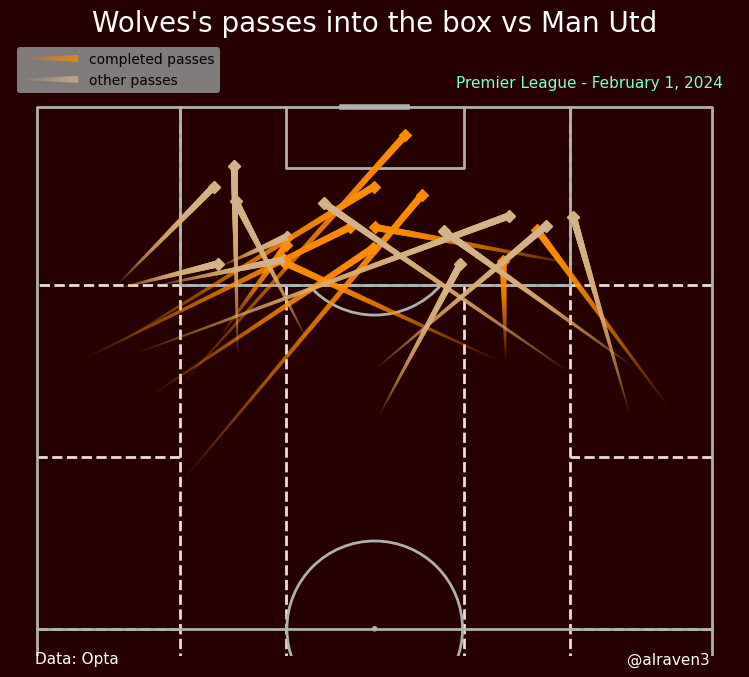

In [15]:
pitch = VerticalPitch(positional=True, pitch_type='opta', half=True, 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(h_passes_intobox.endX, h_passes_intobox.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(h_passes_intobox.x, h_passes_intobox.y,
             h_passes_intobox.endX, h_passes_intobox.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes',ax=ax)
pitch.scatter(h_comp_passes_intobox.endX, h_comp_passes_intobox.endY,color='tan',marker='D',ax=ax)
pitch.lines(h_comp_passes_intobox.x, h_comp_passes_intobox.y,
             h_comp_passes_intobox.endX, h_comp_passes_intobox.endY, 
            comet=True, transparent=True, color='tan', label='other passes', ax=ax)

ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f'{h_team}\'s passes into the box vs {a_team}', fontsize=20,color='white')

fig.text(0.73,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.67,0.1,'@alraven3',color='white',size=11)
fig.text(0.3,0.1,'Data: Opta',color='white',size=11)

Text(0.3, 0.1, 'Data: Opta')

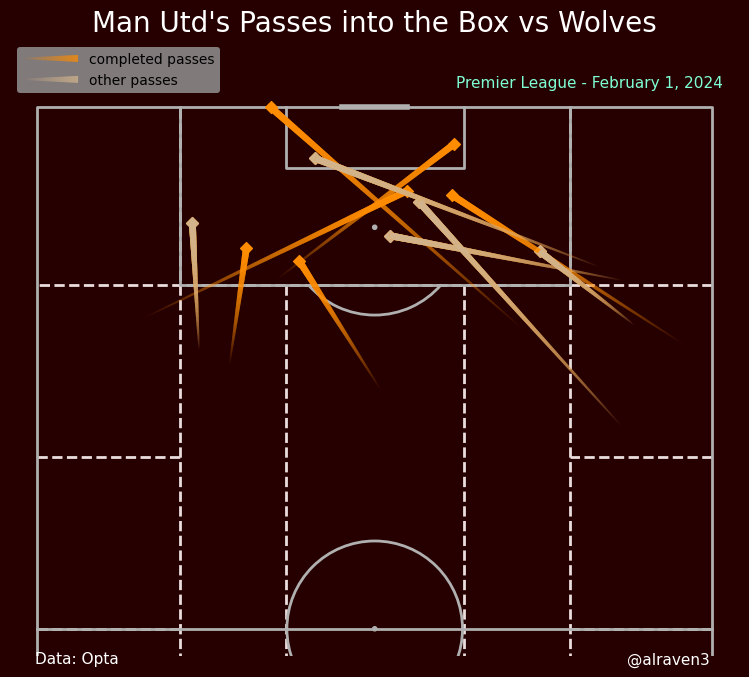

In [16]:
pitch = VerticalPitch(positional=True, pitch_type='opta', half=True, 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(a_passes_intobox.endX, a_passes_intobox.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(a_passes_intobox.x, a_passes_intobox.y,
             a_passes_intobox.endX, a_passes_intobox.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes',ax=ax)
pitch.scatter(a_comp_passes_intobox.endX, a_comp_passes_intobox.endY,color='tan',marker='D',ax=ax)
pitch.lines(a_comp_passes_intobox.x, a_comp_passes_intobox.y,
             a_comp_passes_intobox.endX, a_comp_passes_intobox.endY, 
            comet=True, transparent=True, color='tan', label='other passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f'{a_team}\'s Passes into the Box vs {h_team}', fontsize=20,color='white')

fig.text(0.73,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.67,0.1,'@alraven3',color='white',size=11)
fig.text(0.3,0.1,'Data: Opta',color='white',size=11)

**In Own Half**

Text(0.25, 0.1, 'Data: Opta')

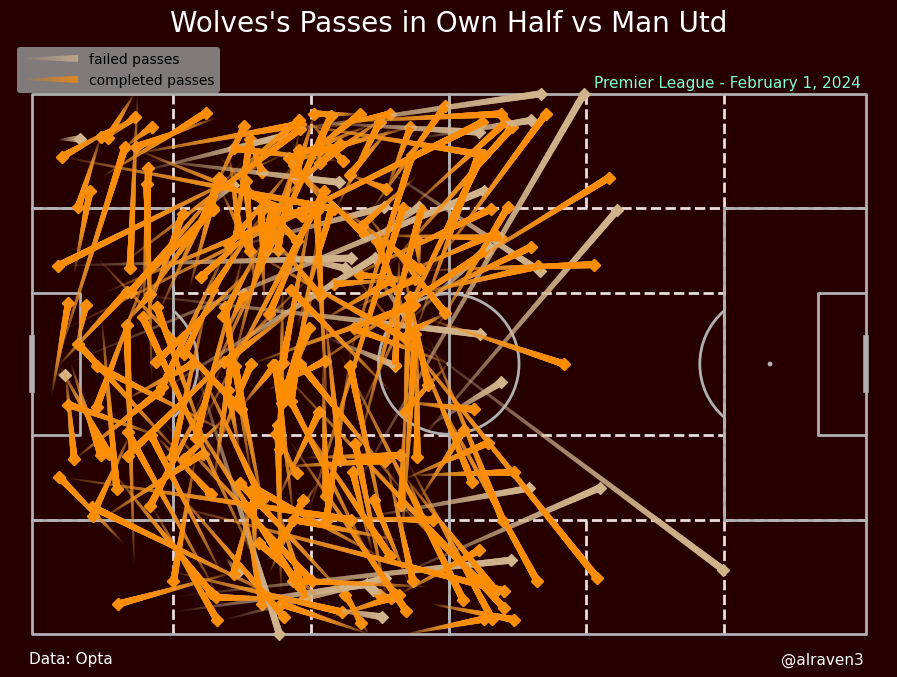

In [17]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(h_ownhalf_passes.endX, h_ownhalf_passes.endY,color='tan',marker='D',ax=ax)
pitch.lines(h_ownhalf_passes.x, h_ownhalf_passes.y,
             h_ownhalf_passes.endX, h_ownhalf_passes.endY, 
            comet=True, transparent=True, color='tan', label='failed passes',ax=ax)
pitch.scatter(h_comp_ownhalf_passes.endX, h_comp_ownhalf_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(h_comp_ownhalf_passes.x, h_comp_ownhalf_passes.y,
             h_comp_ownhalf_passes.endX, h_comp_ownhalf_passes.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f'{h_team}\'s Passes in Own Half vs {a_team}', fontsize=20,color='white')

fig.text(0.77,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.72,0.1,'@alraven3',color='white',size=11)
fig.text(0.25,0.1,'Data: Opta',color='white',size=11)

Text(0.25, 0.1, 'Data: Opta')

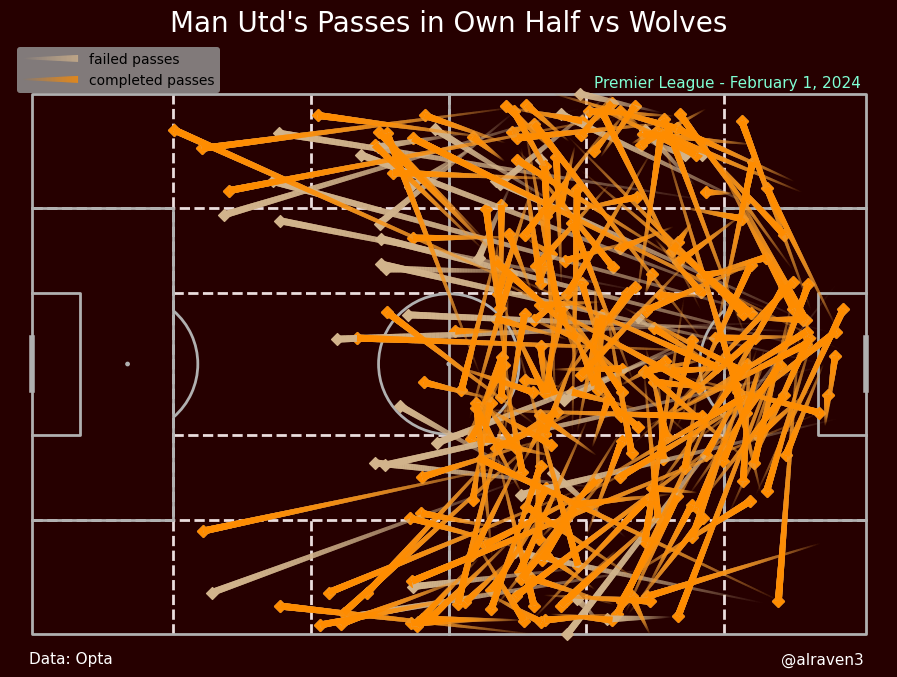

In [18]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(100-a_ownhalf_passes.endX, 100-a_ownhalf_passes.endY,color='tan',marker='D',ax=ax)
pitch.lines(100-a_ownhalf_passes.x, 100-a_ownhalf_passes.y,
             100-a_ownhalf_passes.endX, 100-a_ownhalf_passes.endY, 
            comet=True, transparent=True, color='tan', label='failed passes',ax=ax)
pitch.scatter(100-a_comp_ownhalf_passes.endX, 100-a_comp_ownhalf_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(100-a_comp_ownhalf_passes.x, 100-a_comp_ownhalf_passes.y,
             100-a_comp_ownhalf_passes.endX, 100-a_comp_ownhalf_passes.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f'{a_team}\'s Passes in Own Half vs {h_team}', fontsize=20,color='white')

fig.text(0.77,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.72,0.1,'@alraven3',color='white',size=11)
fig.text(0.25,0.1,'Data: Opta',color='white',size=11)

**In Opponent's Half**

Text(0.25, 0.1, 'Data: Opta')

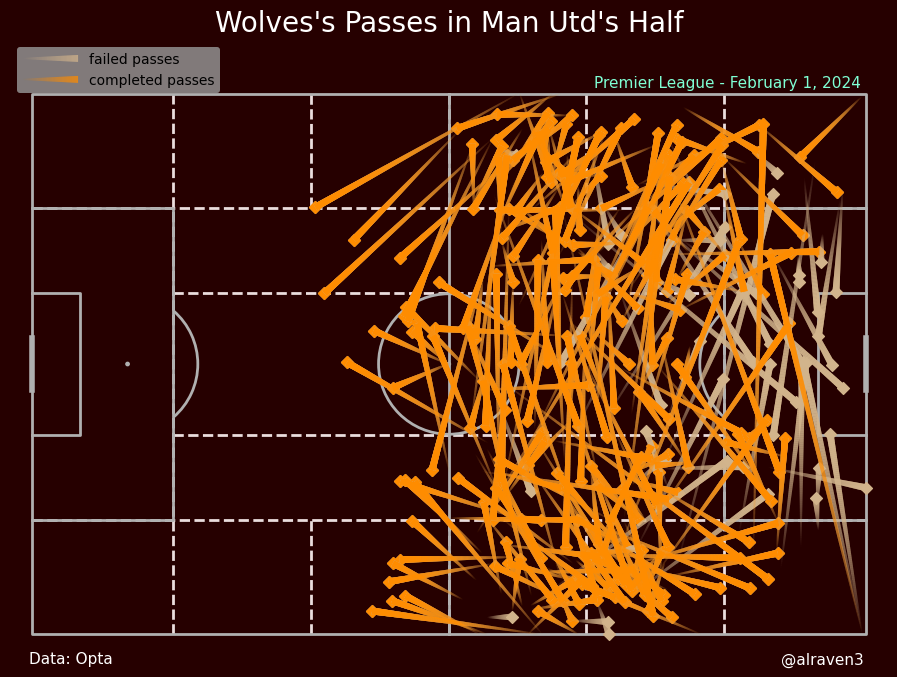

In [19]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(h_opphalf_passes.endX, h_opphalf_passes.endY,color='tan',marker='D',ax=ax)
pitch.lines(h_opphalf_passes.x, h_opphalf_passes.y,
             h_opphalf_passes.endX, h_opphalf_passes.endY, 
            comet=True, transparent=True, color='tan', label='failed passes',ax=ax)
pitch.scatter(h_comp_opphalf_passes.endX, h_comp_opphalf_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(h_comp_opphalf_passes.x, h_comp_opphalf_passes.y,
             h_comp_opphalf_passes.endX, h_comp_opphalf_passes.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f"{h_team}'s Passes in {a_team}'s Half", fontsize=20,color='white')

fig.text(0.77,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.72,0.1,'@alraven3',color='white',size=11)
fig.text(0.25,0.1,'Data: Opta',color='white',size=11)

Text(0.25, 0.1, 'Data: Opta')

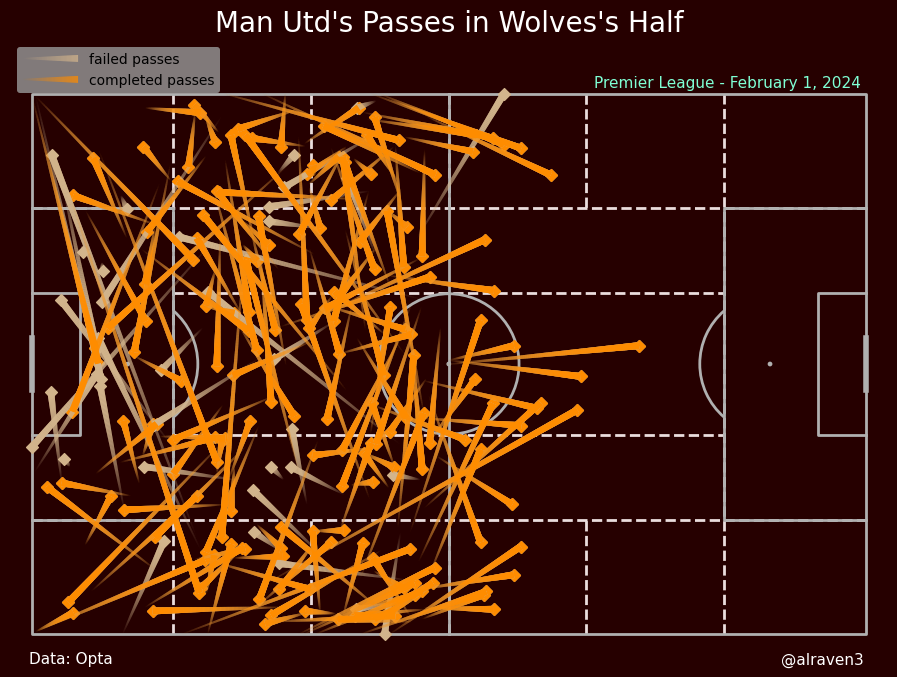

In [20]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(100-a_opphalf_passes.endX, 100-a_opphalf_passes.endY,color='tan',marker='D',ax=ax)
pitch.lines(100-a_opphalf_passes.x, 100-a_opphalf_passes.y,
             100-a_opphalf_passes.endX, 100-a_opphalf_passes.endY, 
            comet=True, transparent=True, color='tan', label='failed passes',ax=ax)
pitch.scatter(100-a_comp_opphalf_passes.endX, 100-a_comp_opphalf_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(100-a_comp_opphalf_passes.x, 100-a_comp_opphalf_passes.y,
             100-a_comp_opphalf_passes.endX, 100-a_comp_opphalf_passes.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f"{a_team}'s Passes in {h_team}'s Half", fontsize=20,color='white')

fig.text(0.77,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.72,0.1,'@alraven3',color='white',size=11)
fig.text(0.25,0.1,'Data: Opta',color='white',size=11)

**Passes into the Final Third**

Text(0.25, 0.1, 'Data: Opta')

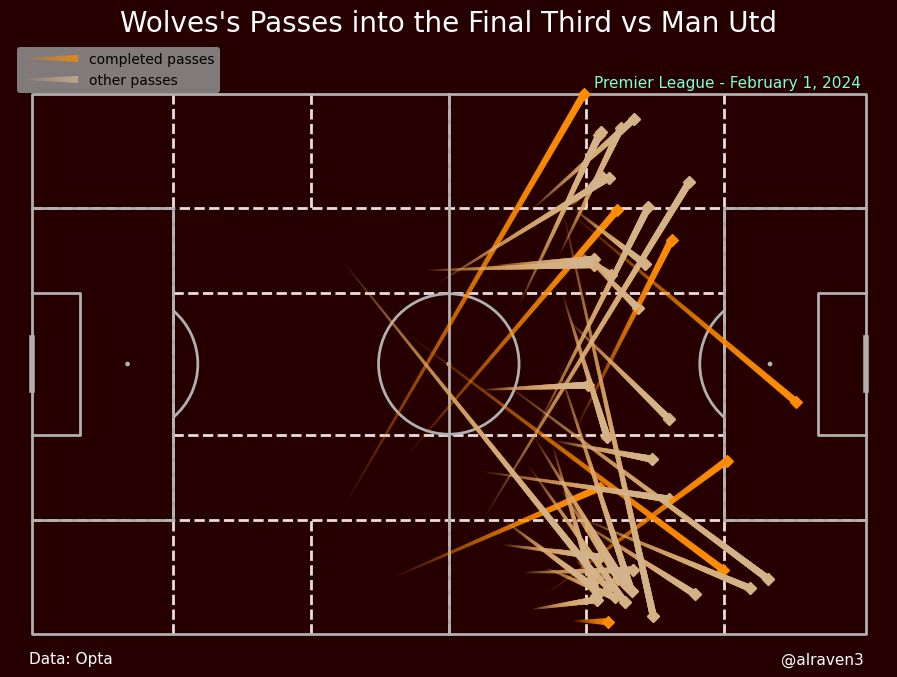

In [21]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(h_final_3rd_passes.endX, h_final_3rd_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(h_final_3rd_passes.x, h_final_3rd_passes.y,
             h_final_3rd_passes.endX, h_final_3rd_passes.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes',ax=ax)
pitch.scatter(h_comp_final3rd_passes.endX, h_comp_final3rd_passes.endY,color='tan',marker='D',ax=ax)
pitch.lines(h_comp_final3rd_passes.x, h_comp_final3rd_passes.y,
             h_comp_final3rd_passes.endX, h_comp_final3rd_passes.endY, 
            comet=True, transparent=True, color='tan', label='other passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f'{h_team}\'s Passes into the Final Third vs {a_team}', fontsize=20,color='white')

fig.text(0.77,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.72,0.1,'@alraven3',color='white',size=11)
fig.text(0.25,0.1,'Data: Opta',color='white',size=11)

Text(0.25, 0.1, 'Data: Opta')

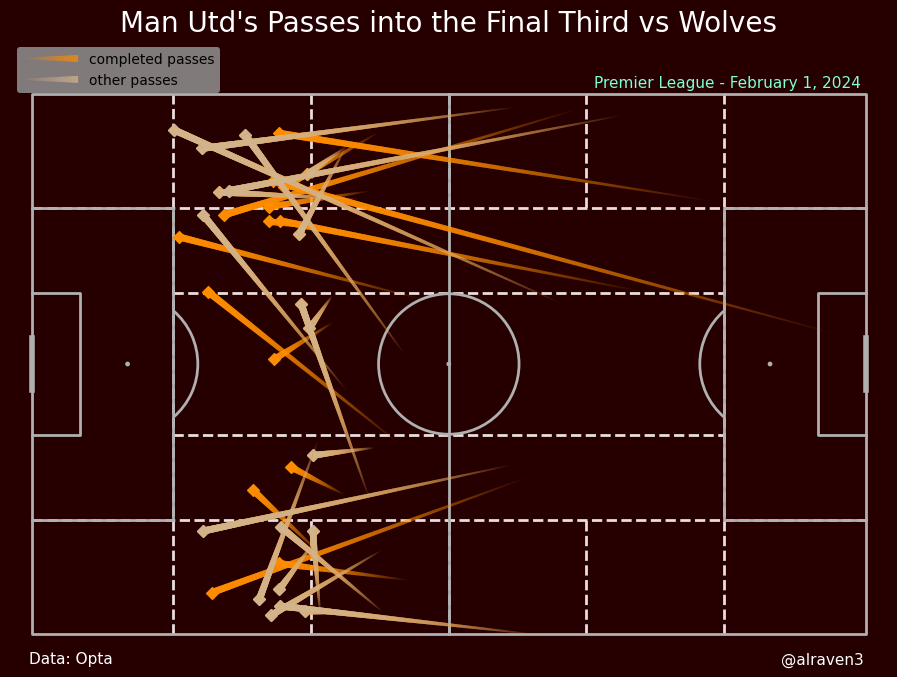

In [22]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.scatter(100-a_final_3rd_passes.endX, 100-a_final_3rd_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(100-a_final_3rd_passes.x, 100-a_final_3rd_passes.y,
             100-a_final_3rd_passes.endX, 100-a_final_3rd_passes.endY, 
            comet=True, transparent=True, color='darkorange', label='completed passes',ax=ax)
pitch.scatter(100-a_comp_final3rd_passes.endX, 100-a_comp_final3rd_passes.endY,color='tan',marker='D',ax=ax)
pitch.lines(100-a_comp_final3rd_passes.x, 100-a_comp_final3rd_passes.y,
             100-a_comp_final3rd_passes.endX, 100-a_comp_final3rd_passes.endY, 
            comet=True, transparent=True, color='tan', label='other passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f'{a_team}\'s Passes into the Final Third vs {h_team}', fontsize=20,color='white')

fig.text(0.77,0.82,f"{competition_date}",ha='right',color='aquamarine',size=11)
fig.text(0.72,0.1,'@alraven3',color='white',size=11)
fig.text(0.25,0.1,'Data: Opta',color='white',size=11)

# Shotmaps

C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\839731924.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_shots['on_target'] = np.where((h_shots['endX'] >= 100) & (h_shots['goalMouthY'] >= 45) & (h_shots['goalMouthY'] <= 55), True, False)
C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\839731924.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_shots['missed'] = ~h_shots['on_target']


Text(0.18, 0.1, 'Data: Opta')

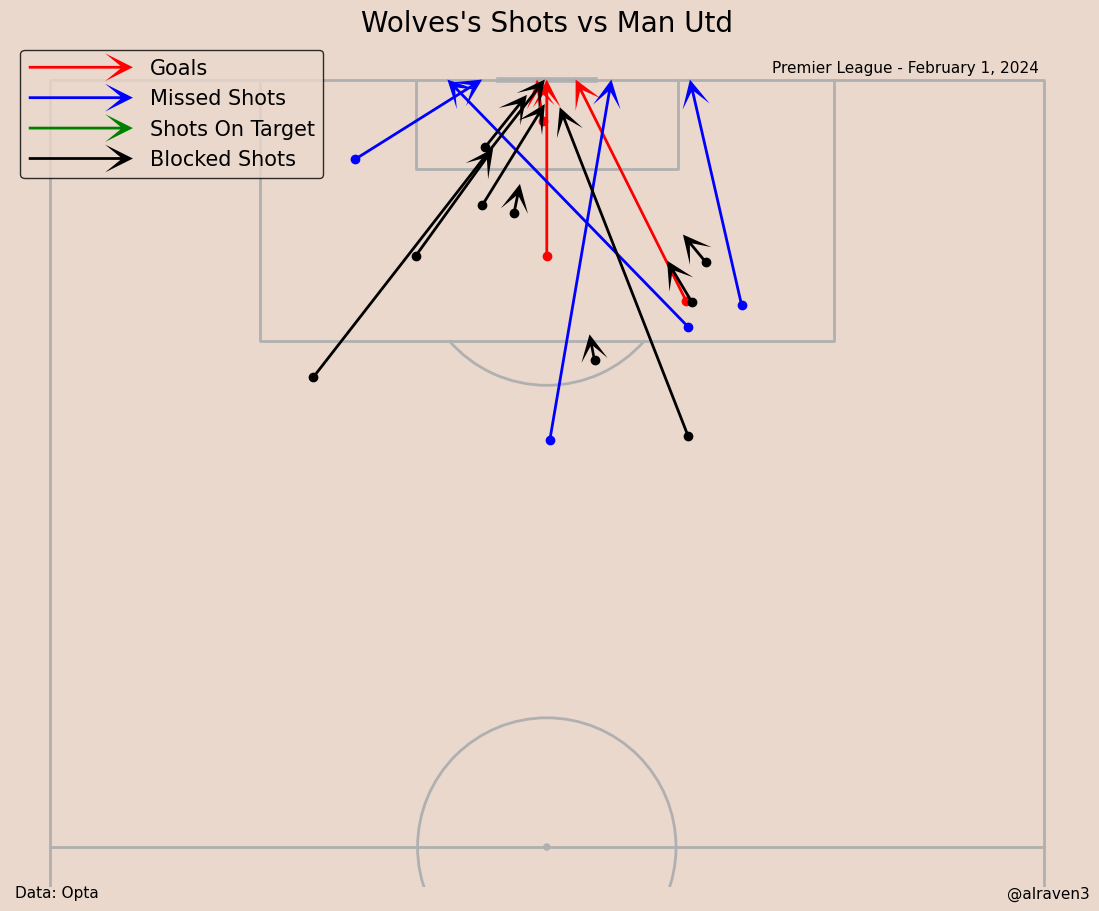

In [23]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#ead8cd', half=True)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

df_missed_shots = df1.loc[df1['type_displayName']=='MissedShots']
h_missed = df_missed_shots.loc[df_missed_shots['teamId']==h_id]
# Update 'endX' column for unblocked shots
h_shots.loc[h_shots['blockedX'].isna(), 'endX'] = 100
h_goals.loc[h_goals['blockedX'].isna(), 'endX'] = 100
h_missed.loc[h_missed['blockedX'].isna(), 'endX'] = 100

# Differentiate between blocked shots, goals, on-target shots, and missed shots
h_shots['on_target'] = np.where((h_shots['endX'] >= 100) & (h_shots['goalMouthY'] >= 45) & (h_shots['goalMouthY'] <= 55), True, False)
h_shots['missed'] = ~h_shots['on_target']

# Plot goals as red arrows
pitch.scatter(h_goals['x'], h_goals['y'],color='red',ax=ax)
pitch.arrows(h_goals['x'], h_goals['y'], h_goals['endX'], h_goals['goalMouthY'],
             width=2, headwidth=10, headlength=10, color='red', label='Goals',ax=ax)

# Plot missed shots (off target) as blue arrows
#missed_shots = h_shots[(h_shots['missed']) & (h_shots['isGoal'] != 1)]
pitch.scatter(h_missed.x,h_missed.y,color='blue',ax=ax)
#pitch.arrows(missed_shots['x'], missed_shots['y'], missed_shots['endX'], missed_shots['goalMouthY'],
#             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)
pitch.arrows(h_missed.x,h_missed.y,h_missed.endX,h_missed.goalMouthY,
             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)

# Plot on-target shots as green arrows (excluding goals)
on_target_shots = h_shots[(h_shots['on_target']) & (h_shots['isGoal'] != 1)]
#on_target_shots = h_shots(h_shots['on_target']==True).copy()
pitch.scatter(on_target_shots['x'], on_target_shots['y'],color='green',ax=ax)
pitch.arrows(on_target_shots['x'], on_target_shots['y'], on_target_shots['endX'], on_target_shots['goalMouthY'],
             width=2, headwidth=10, headlength=10, color='green', label='Shots On Target', ax=ax)

# Plot blocked shots as black arrows
blocked_shots = h_shots[h_shots['blockedX'].notna()]
pitch.scatter(blocked_shots['x'], blocked_shots['y'],color='black',ax=ax)
pitch.arrows(blocked_shots['x'], blocked_shots['y'], blocked_shots['blockedX'], blocked_shots['blockedY'],
             width=2, headwidth=10, headlength=10, color='black', label='Blocked Shots',ax=ax)
#title
fig.set_facecolor('#ead8cd')
ax_title = ax.set_title(f'{h_team}\'s Shots vs {a_team}', fontsize=20,color='black')

# Add a legend to the plot
ax.legend(facecolor='#ead8cd', edgecolor='black',labelcolor='black',fontsize=15,loc='upper left', handlelength=5)
fig.text(0.82,0.85,f"{competition_date}",ha='right',color='black',size=11)
fig.text(0.8,0.1,'@alraven3',color='black',size=11)
fig.text(0.18,0.1,'Data: Opta',color='black',size=11)

C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\2555133148.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_shots['on_target'] = np.where((a_shots['endX'] >= 100) & (a_shots['goalMouthY'] >= 45) & (a_shots['goalMouthY'] <= 55), True, False)
C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\2555133148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_shots['missed'] = ~a_shots['on_target']


Text(0.18, 0.1, 'Data: Opta')

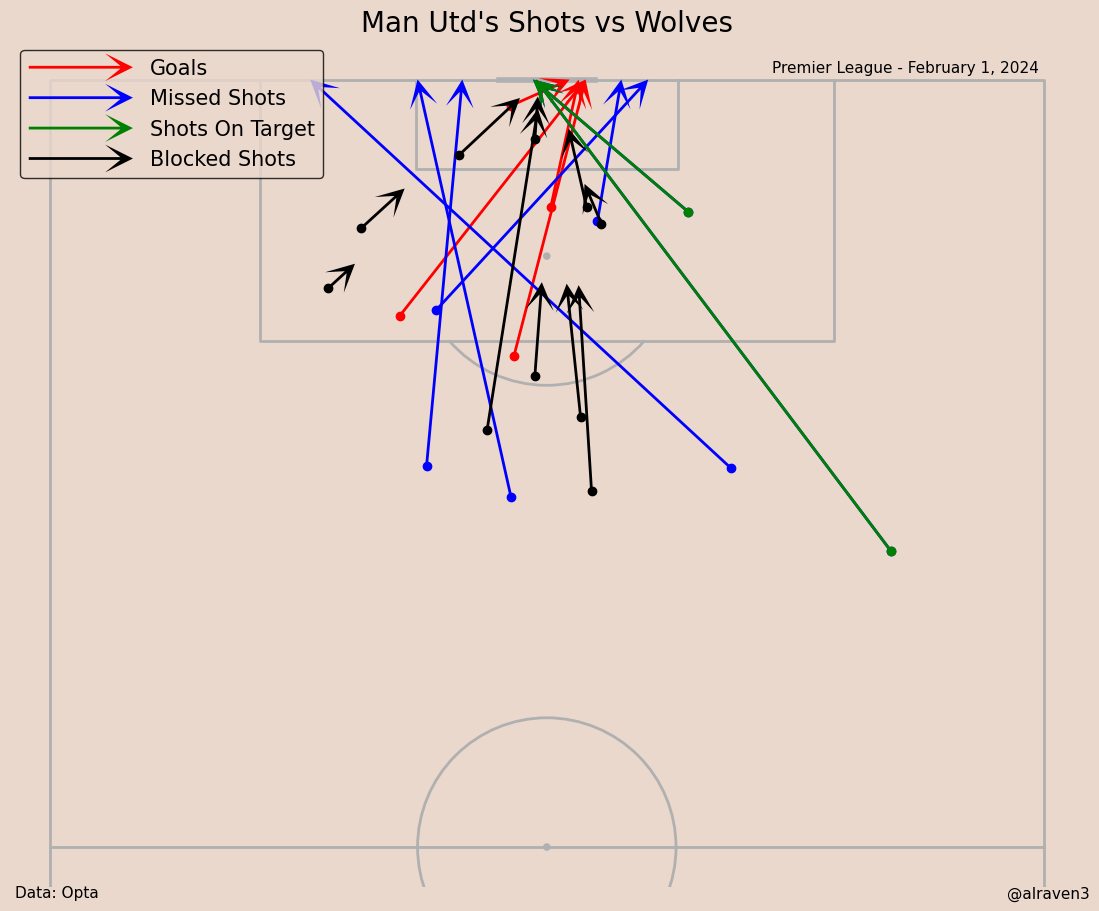

In [24]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#ead8cd', half=True)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

df_missed_shots = df1.loc[df1['type_displayName']=='MissedShots']
a_missed = df_missed_shots.loc[df_missed_shots['teamId']==a_id]
# Update 'endX' column for unblocked shots
a_shots.loc[a_shots['blockedX'].isna(), 'endX'] = 100
a_goals.loc[a_goals['blockedX'].isna(), 'endX'] = 100
a_missed.loc[a_missed['blockedX'].isna(), 'endX'] = 100

# Differentiate between blocked shots, goals, on-target shots, and missed shots
a_shots['on_target'] = np.where((a_shots['endX'] >= 100) & (a_shots['goalMouthY'] >= 45) & (a_shots['goalMouthY'] <= 55), True, False)
a_shots['missed'] = ~a_shots['on_target']

# Plot goals as red arrows
pitch.scatter(a_goals['x'], a_goals['y'],color='red',ax=ax)
pitch.arrows(a_goals['x'], a_goals['y'], a_goals['endX'], a_goals['goalMouthY'],
             width=2, headwidth=10, headlength=10, color='red', label='Goals',ax=ax)

# Plot missed shots (off target) as blue arrows
#missed_shots = h_shots[(h_shots['missed']) & (h_shots['isGoal'] != 1)]
pitch.scatter(a_missed.x,a_missed.y,color='blue',ax=ax)
#pitch.arrows(missed_shots['x'], missed_shots['y'], missed_shots['endX'], missed_shots['goalMouthY'],
#             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)
pitch.arrows(a_missed.x,a_missed.y,a_missed.endX,a_missed.goalMouthY,
             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)

# Plot on-target shots as green arrows (excluding goals)
on_target_shots = a_shots[(a_shots['on_target']) & (a_shots['isGoal'] != 1)]
pitch.scatter(on_target_shots['x'], on_target_shots['y'],color='green',ax=ax)
pitch.arrows(on_target_shots['x'], on_target_shots['y'], on_target_shots['endX'], on_target_shots['goalMouthY'],
             width=2, headwidth=10, headlength=10, color='green', label='Shots On Target', ax=ax)

# Plot blocked shots as black arrows
blocked_shots = a_shots[a_shots['blockedX'].notna()]
pitch.scatter(blocked_shots['x'], blocked_shots['y'],color='black',ax=ax)
pitch.arrows(blocked_shots['x'], blocked_shots['y'], blocked_shots['blockedX'], blocked_shots['blockedY'],
             width=2, headwidth=10, headlength=10, color='black', label='Blocked Shots',ax=ax)
#title
fig.set_facecolor('#ead8cd')
ax_title = ax.set_title(f'{a_team}\'s Shots vs {h_team}', fontsize=20,color='black')

# Add a legend to the plot
ax.legend(facecolor='#ead8cd', edgecolor='black',labelcolor='black',fontsize=15,loc='upper left', handlelength=5)
fig.text(0.82,0.85,f"{competition_date}",ha='right',color='black',size=11)
fig.text(0.8,0.1,'@alraven3',color='black',size=11)
fig.text(0.18,0.1,'Data: Opta',color='black',size=11)

C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\580851905.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_shots['on_target'] = np.where((h_shots['endX'] >= 100) & (h_shots['goalMouthY'] >= 45) & (h_shots['goalMouthY'] <= 55), True, False)
C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\580851905.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_shots['missed'] = ~h_shots['on_target']


Text(0.18, 0.1, 'Data: Opta')

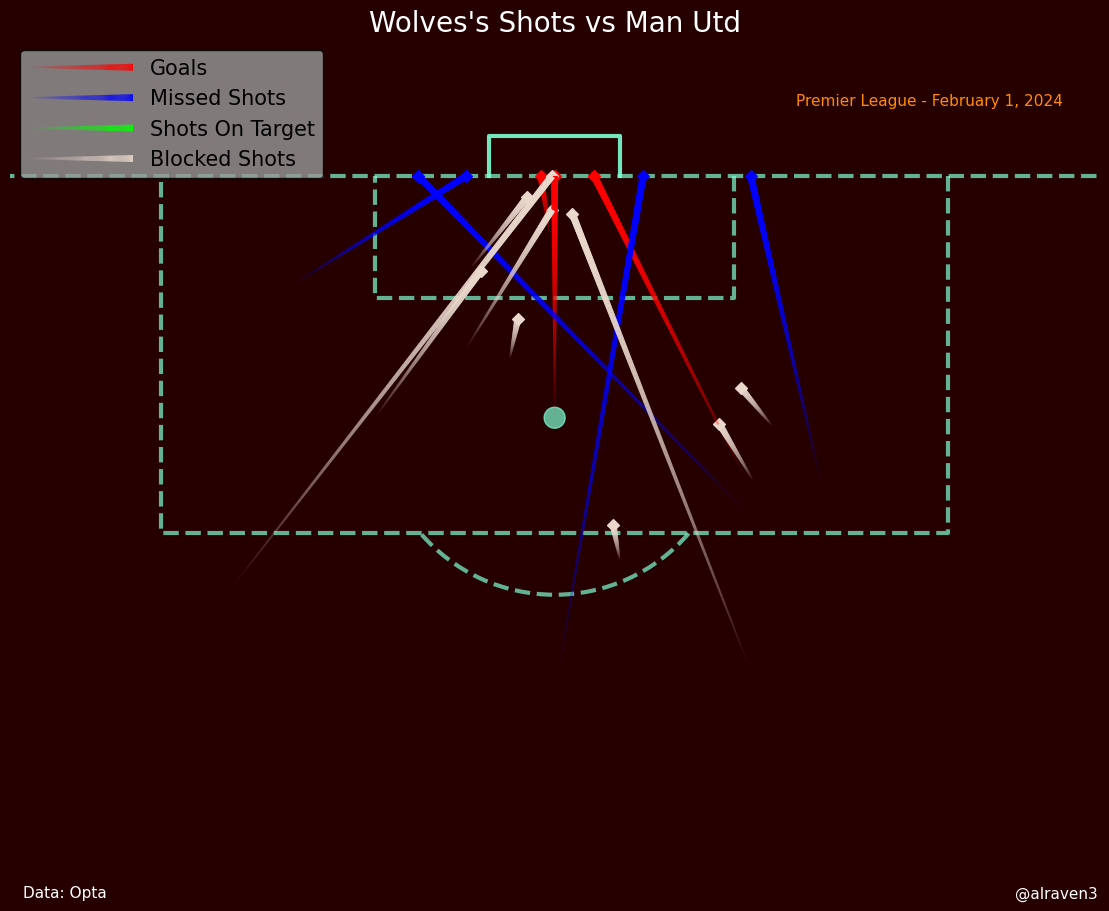

In [25]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#260000', half=True,
                      pad_left=-10,pad_right=-10,pad_top=10,pad_bottom=-25,
                      spot_scale=0.005,linewidth=3,line_alpha=0.7, goal_alpha=0.9,
                      goal_type='box',linestyle='--',line_color='aquamarine')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

df_missed_shots = df1.loc[df1['type_displayName']=='MissedShots']
h_missed = df_missed_shots.loc[df_missed_shots['teamId']==h_id]
# Update 'endX' column for unblocked shots
h_shots.loc[h_shots['blockedX'].isna(), 'endX'] = 100
h_goals.loc[h_goals['blockedX'].isna(), 'endX'] = 100
h_missed.loc[h_missed['blockedX'].isna(), 'endX'] = 100

# Differentiate between blocked shots, goals, on-target shots, and missed shots
h_shots['on_target'] = np.where((h_shots['endX'] >= 100) & (h_shots['goalMouthY'] >= 45) & (h_shots['goalMouthY'] <= 55), True, False)
h_shots['missed'] = ~h_shots['on_target']

# Plot goals as red arrows
pitch.scatter(h_goals['endX'], h_goals['goalMouthY'],marker='D',color='red',ax=ax)
pitch.lines(h_goals['x'], h_goals['y'], h_goals['endX'], h_goals['goalMouthY'], comet=True,
            transparent=True, color='red', label='Goals',ax=ax)

# Plot missed shots (off target) as blue arrows
#missed_shots = h_shots[(h_shots['missed']) & (h_shots['isGoal'] != 1)]
pitch.scatter(h_missed.endX,h_missed.goalMouthY,color='blue',marker='D',ax=ax)
#pitch.arrows(missed_shots['x'], missed_shots['y'], missed_shots['endX'], missed_shots['goalMouthY'],
#             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)
pitch.lines(h_missed.x,h_missed.y,h_missed.endX,h_missed.goalMouthY,
             comet=True, transparent=True, color='blue', label='Missed Shots', ax=ax)

# Plot on-target shots as green arrows (excluding goals)
on_target_shots = h_shots[(h_shots['on_target']) & (h_shots['isGoal'] != 1)]
pitch.scatter(on_target_shots['endX'], on_target_shots['goalMouthY'],color='lime',marker='D',ax=ax)
pitch.lines(on_target_shots['x'], on_target_shots['y'], on_target_shots['endX'], on_target_shots['goalMouthY'],
             comet=True, transparent=True,  color='lime', label='Shots On Target', ax=ax)

# Plot blocked shots as black arrows
blocked_shots = h_shots[h_shots['blockedX'].notna()]
#pitch.scatter(blocked_shots['x'], blocked_shots['y'],color='black',ax=ax)
pitch.scatter(blocked_shots['blockedX'], blocked_shots['blockedY'],marker='D',color='#ead8cd',ax=ax)
pitch.lines(blocked_shots['x'], blocked_shots['y'], blocked_shots['blockedX'], blocked_shots['blockedY'],
             comet=True, transparent=True, color='#ead8cd', label='Blocked Shots',ax=ax)
#title
fig.set_facecolor('#260000')
ax_title = ax.set_title(f'{h_team}\'s Shots vs {a_team}', fontsize=20,color='white')

# Add a legend to the plot
ax.legend(facecolor='#999999', edgecolor='black',labelcolor='black',fontsize=15,loc='upper left', handlelength=5)
fig.text(0.83,0.82,f"{competition_date}",ha='right',color='darkorange',size=11)
fig.text(0.8,0.1,'@alraven3',color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\2225348616.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_shots['on_target'] = np.where((a_shots['endX'] >= 100) & (a_shots['goalMouthY'] >= 45) & (a_shots['goalMouthY'] <= 55), True, False)
C:\Users\Al Raven\AppData\Local\Temp\ipykernel_908\2225348616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_shots['missed'] = ~a_shots['on_target']


Text(0.18, 0.1, 'Data: Opta')

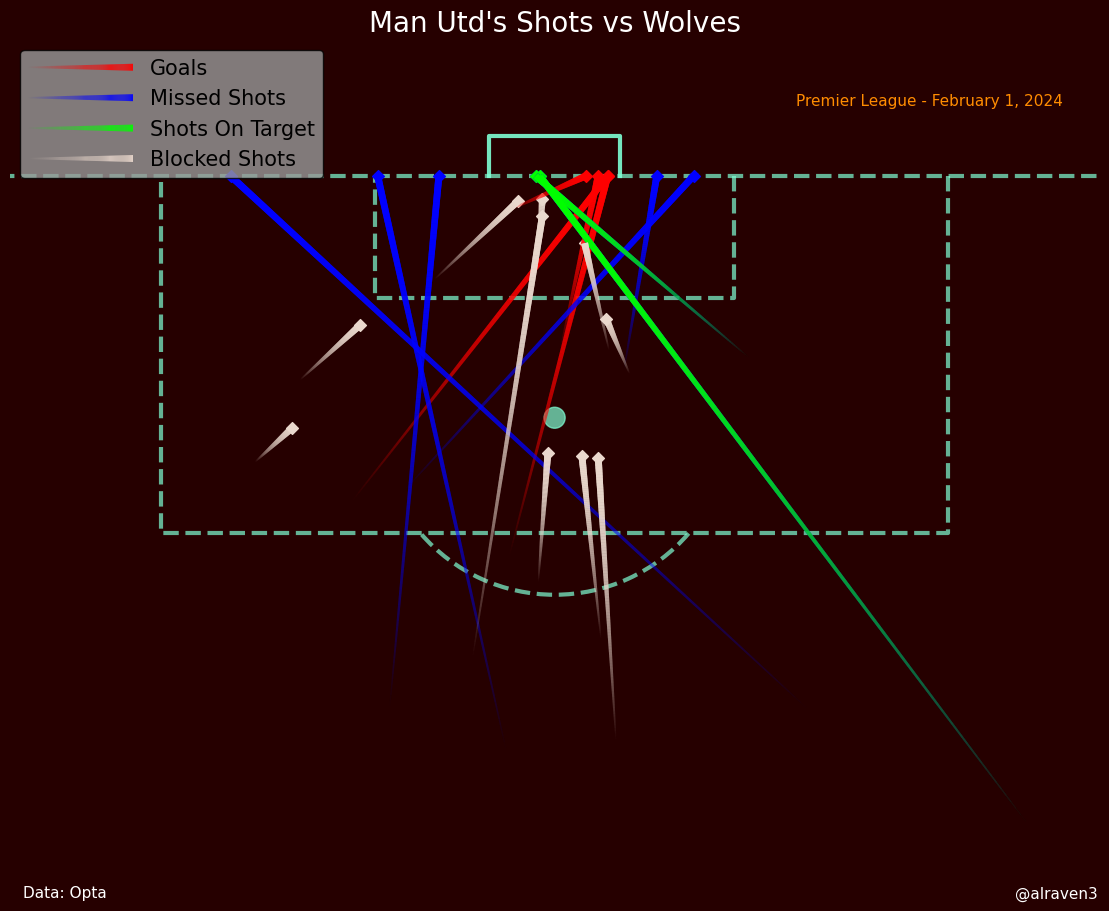

In [26]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#260000', half=True,
                      pad_left=-10,pad_right=-10,pad_top=10,pad_bottom=-25,
                      spot_scale=0.005,linewidth=3,line_alpha=0.7, goal_alpha=0.9,
                      goal_type='box',linestyle='--',line_color='aquamarine')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

df_missed_shots = df1.loc[df1['type_displayName']=='MissedShots']
a_missed = df_missed_shots.loc[df_missed_shots['teamId']==a_id]
# Update 'endX' column for unblocked shots
a_shots.loc[a_shots['blockedX'].isna(), 'endX'] = 100
a_goals.loc[a_goals['blockedX'].isna(), 'endX'] = 100
a_missed.loc[a_missed['blockedX'].isna(), 'endX'] = 100

# Differentiate between blocked shots, goals, on-target shots, and missed shots
a_shots['on_target'] = np.where((a_shots['endX'] >= 100) & (a_shots['goalMouthY'] >= 45) & (a_shots['goalMouthY'] <= 55), True, False)
a_shots['missed'] = ~a_shots['on_target']

# Plot goals as red arrows
pitch.scatter(a_goals['endX'], a_goals['goalMouthY'],marker='D',color='red',ax=ax)
pitch.lines(a_goals['x'], a_goals['y'], a_goals['endX'], a_goals['goalMouthY'], comet=True,
            transparent=True, color='red', label='Goals',ax=ax)

# Plot missed shots (off target) as blue arrows
#missed_shots = h_shots[(h_shots['missed']) & (h_shots['isGoal'] != 1)]
pitch.scatter(a_missed.endX,a_missed.goalMouthY,color='blue',marker='D',ax=ax)
#pitch.arrows(missed_shots['x'], missed_shots['y'], missed_shots['endX'], missed_shots['goalMouthY'],
#             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)
pitch.lines(a_missed.x,a_missed.y,a_missed.endX,a_missed.goalMouthY,
             comet=True, transparent=True, color='blue', label='Missed Shots', ax=ax)

# Plot on-target shots as green arrows (excluding goals)
on_target_shots = a_shots[(a_shots['on_target']) & (a_shots['isGoal'] != 1)]
pitch.scatter(on_target_shots['endX'], on_target_shots['goalMouthY'],color='lime',marker='D',ax=ax)
pitch.lines(on_target_shots['x'], on_target_shots['y'], on_target_shots['endX'], on_target_shots['goalMouthY'],
             comet=True, transparent=True,  color='lime', label='Shots On Target', ax=ax)

# Plot blocked shots as black arrows
blocked_shots = a_shots[a_shots['blockedX'].notna()]
#pitch.scatter(blocked_shots['x'], blocked_shots['y'],color='black',ax=ax)
pitch.scatter(blocked_shots['blockedX'], blocked_shots['blockedY'],marker='D',color='#ead8cd',ax=ax)
pitch.lines(blocked_shots['x'], blocked_shots['y'], blocked_shots['blockedX'], blocked_shots['blockedY'],
             comet=True, transparent=True, color='#ead8cd', label='Blocked Shots',ax=ax)
#title
fig.set_facecolor('#260000')
ax_title = ax.set_title(f'{a_team}\'s Shots vs {h_team}', fontsize=20,color='white')

# Add a legend to the plot
ax.legend(facecolor='#999999', edgecolor='black',labelcolor='black',fontsize=15,loc='upper left', handlelength=5)
fig.text(0.83,0.82,f"{competition_date}",ha='right',color='darkorange',size=11)
fig.text(0.8,0.1,'@alraven3',color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

# Goalkeeper Action Map 

Text(0.3, 0.1, 'Data: Opta')

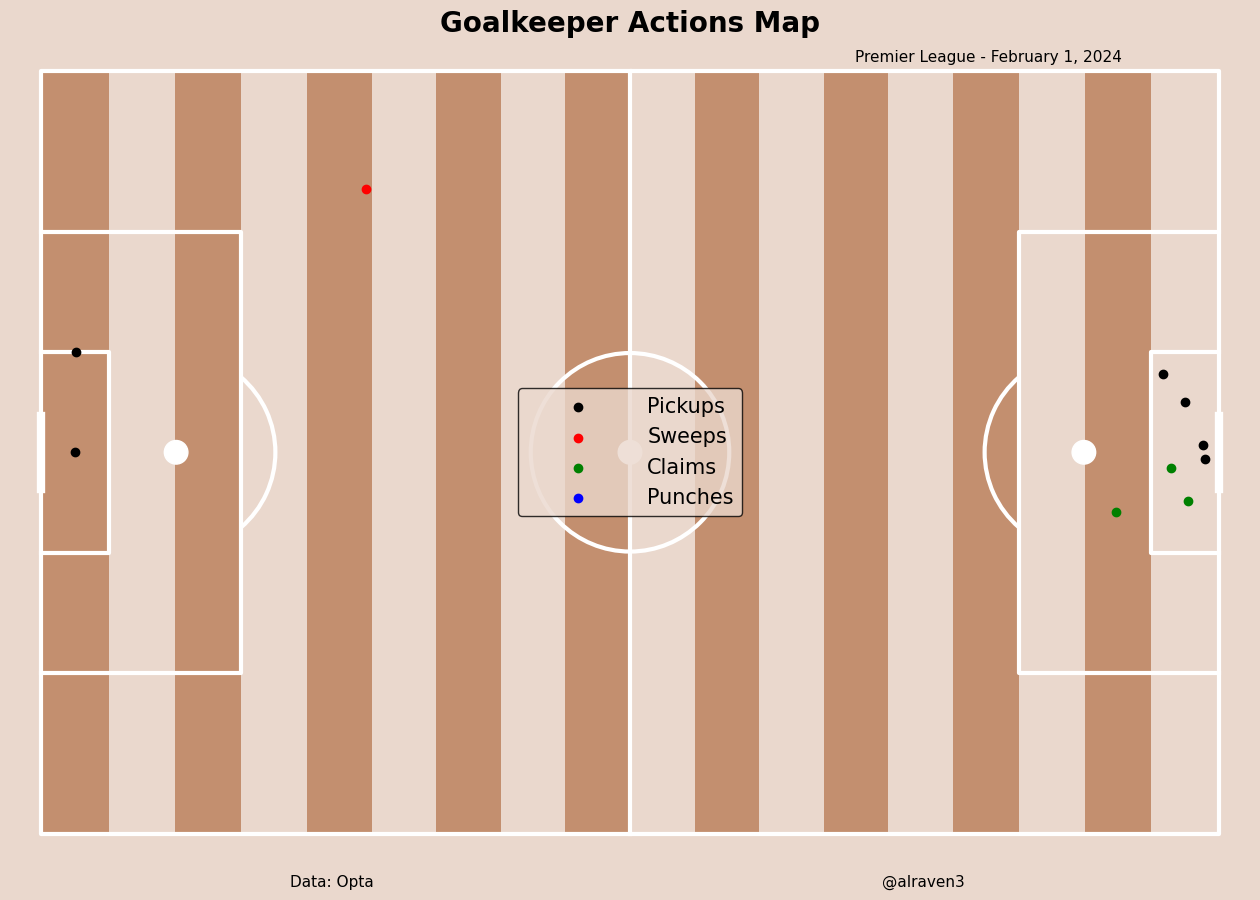

In [27]:
h_gk = gk_actions[gk_actions.teamId==h_id]
h_pickups = h_gk.loc[gk_actions.type_displayName=='KeeperPickup']
h_sweeps = h_gk.loc[gk_actions.type_displayName=='KeeperSweeper']
h_claims = h_gk.loc[gk_actions.type_displayName=='Claim']
h_punches = h_gk.loc[gk_actions.type_displayName=='Punch']
a_gk = gk_actions[gk_actions.teamId==a_id]
a_pickups = a_gk.loc[gk_actions.type_displayName=='KeeperPickup']
a_sweeps = a_gk.loc[gk_actions.type_displayName=='KeeperSweeper']
a_claims = a_gk.loc[gk_actions.type_displayName=='Claim']
a_punches = a_gk.loc[gk_actions.type_displayName=='Punch']
pitch = Pitch(pitch_type='opta', pitch_color='#ead8cd',
             spot_scale=0.01,linewidth=3, line_color='white',
              stripe_color='#c38f6f', stripe=True)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
pitch.scatter(h_pickups.x,h_pickups.y,color='black',label='Pickups',ax=ax)
pitch.scatter(h_sweeps.x,h_sweeps.y,color='red',label='Sweeps',ax=ax)
pitch.scatter(h_claims.x,h_claims.y,color='green',label='Claims',ax=ax)
pitch.scatter(h_punches.x,h_punches.y,color='blue',label='Punches',ax=ax)
pitch.scatter(100-a_pickups.x,100-a_pickups.y,color='black',ax=ax)
pitch.scatter(100-a_sweeps.x,100-a_sweeps.y,color='red',ax=ax)
pitch.scatter(100-a_claims.x,100-a_claims.y,color='green',ax=ax)
pitch.scatter(100-a_punches.x,100-a_punches.y,color='blue',ax=ax)
ax.legend(facecolor='#ead8cd', edgecolor='black',labelcolor='black',fontsize=15,loc='center', handlelength=5)
fig.set_facecolor('#ead8cd')
ax_title = ax.set_title(f'Goalkeeper Actions Map', fontsize=20,color='black',fontweight='bold')
fig.text(0.82,0.85,f"{competition_date}",ha='right',color='black',size=11)
fig.text(0.67,0.1,'@alraven3',color='black',size=11)
fig.text(0.3,0.1,'Data: Opta',color='black',size=11)

Text(0.3, 0.1, 'Data: Opta')

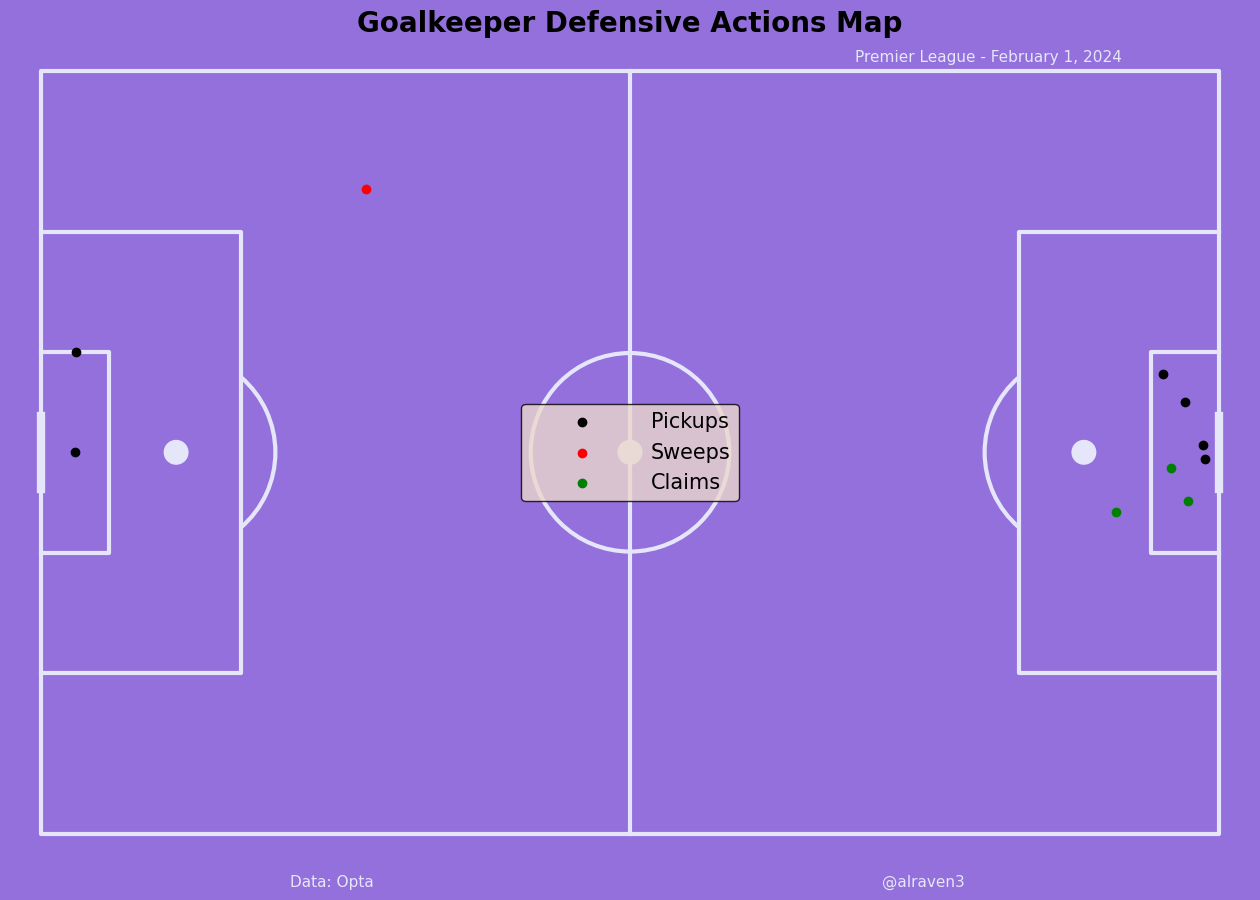

In [28]:
# Initialize the pitch
pitch = Pitch(pitch_type='opta', pitch_color='mediumpurple',spot_scale=0.01,linewidth=3, line_color='lavender')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

# Set with all action types
action_types = {'Pickups', 'Sweeps', 'Claims', 'Punches'}

# Iterate over each row in the DataFrame
for index, row in gk_actions.iterrows():
    # Skip rows that do not match the four action types
    if row['type_displayName'] not in ['KeeperPickup', 'KeeperSweeper', 'Claim', 'Punch']:
        continue

    # Initialize variables
    action_label = None

    # Determine the action type and corresponding color
    if row['type_displayName'] == 'KeeperPickup':
        color = 'black'
        action_type = 'Pickups'
    elif row['type_displayName'] == 'KeeperSweeper':
        color = 'red'
        action_type = 'Sweeps'
    elif row['type_displayName'] == 'Claim':
        color = 'green'
        action_type = 'Claims'
    elif row['type_displayName'] == 'Punch':
        color = 'blue'
        action_type = 'Punches'

    # Check if this action type is to be plotted for the first time
    if action_type in action_types:
        action_label = action_type
        action_types.remove(action_type)

    # Adjust coordinates for the away team
    x, y = (row['x'], row['y']) if row['teamId'] == h_id else (100 - row['x'], 100 - row['y'])

    # Plot the action
    pitch.scatter(x, y, color=color, label=action_label, ax=ax)

# Set legend and other plot properties
ax.legend(facecolor='#ead8cd', edgecolor='black', labelcolor='black', fontsize=15, loc='center', handlelength=5)
fig.set_facecolor('mediumpurple')
ax_title = ax.set_title('Goalkeeper Defensive Actions Map', fontsize=20, color='black',fontweight='bold')
fig.text(0.82,0.85,f"{competition_date}",ha='right',color='lavender',size=11)
fig.text(0.67,0.1,'@alraven3',color='lavender',size=11)
fig.text(0.3,0.1,'Data: Opta',color='lavender',size=11)

# Heatmaps

*You can switch between passes, touches, shots, etc. by looking at the names of the relevant dataframes at the beginning and putting them in place of what's in e.g. "data=a_touches" or "pitch.bin_statistic(a_passes.x, a_passes.y...", and so on...*

Text(0.3, 0.1, 'Data: Opta')

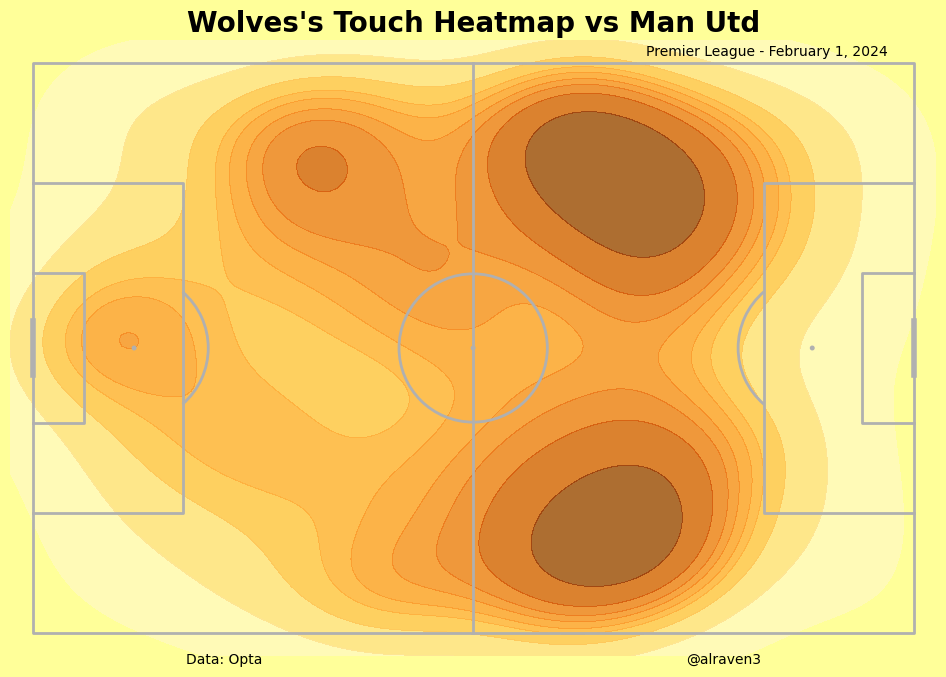

In [29]:
fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#ffff99')


#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#ffff99',line_zorder=2)

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=h_touches,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        
        alpha=.7,
        n_levels=10,
        cmap='YlOrBr'
)

plt.title(f"{h_team}'s Touch Heatmap vs {a_team}",size=20,fontweight='bold')
fig.text(0.82,0.86,f"{competition_date}",ha='right',color='black',size=10)
fig.text(0.67,0.1,'@alraven3',color='black',size=10)
fig.text(0.3,0.1,'Data: Opta',color='black',size=10)


Text(0.3, 0.1, 'Data: Opta')

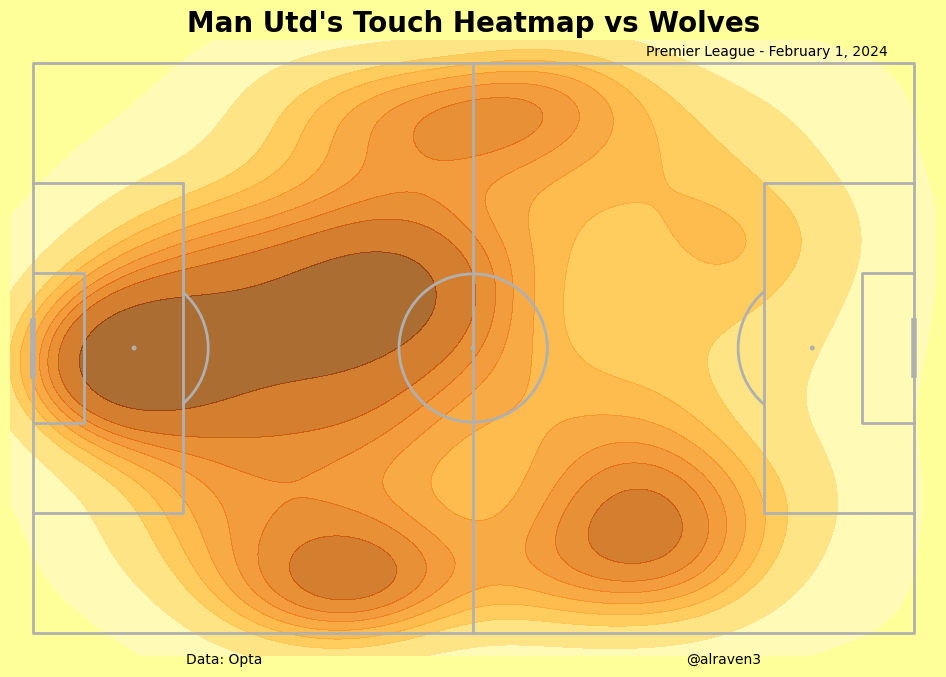

In [30]:
fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#ffff99')


#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#ffff99',line_zorder=2)

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=a_touches,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        
        alpha=.7,
        n_levels=10,
        cmap='YlOrBr'
)

plt.title(f"{a_team}'s Touch Heatmap vs {h_team}",size=20,fontweight='bold')
fig.text(0.82,0.86,f"{competition_date}",ha='right',color='black',size=10)
fig.text(0.67,0.1,'@alraven3',color='black',size=10)
fig.text(0.3,0.1,'Data: Opta',color='black',size=10)


Text(0.3, 0.1, 'Data: Opta')

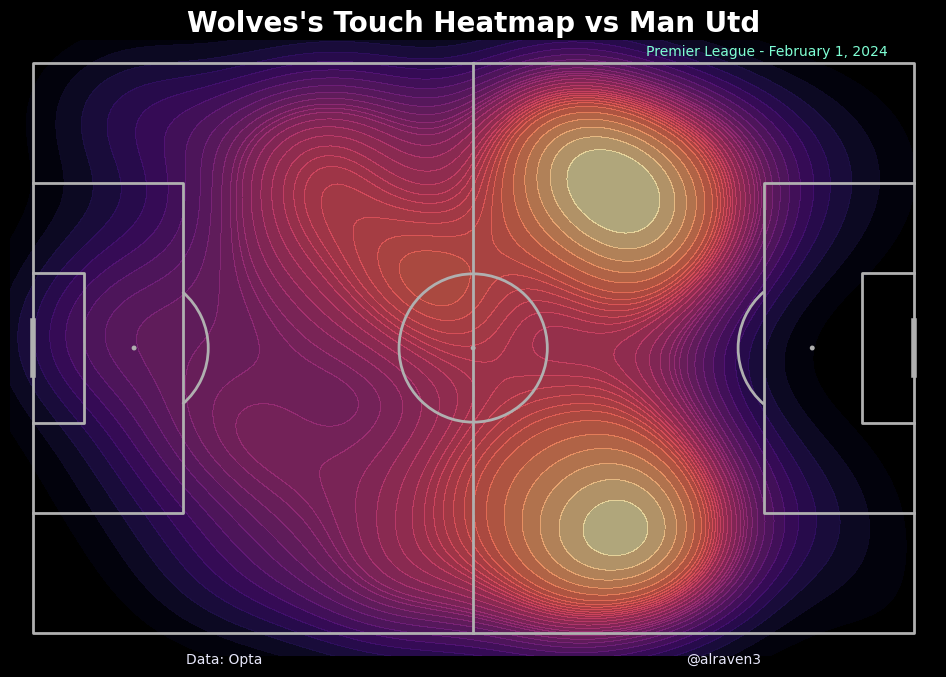

In [31]:
fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#000000')

#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#000000',line_zorder=2)

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=h_passes,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        
        alpha=.7,
        n_levels=30,
        cmap='magma'
)

plt.title(f"{h_team}'s Touch Heatmap vs {a_team}",size=20,color='white',fontweight='bold')
fig.text(0.82,0.86,f"{competition_date}",ha='right',color='aquamarine',size=10)
fig.text(0.67,0.1,'@alraven3',color='lavender',size=10)
fig.text(0.3,0.1,'Data: Opta',color='lavender',size=10)


Text(0.3, 0.1, 'Data: Opta')

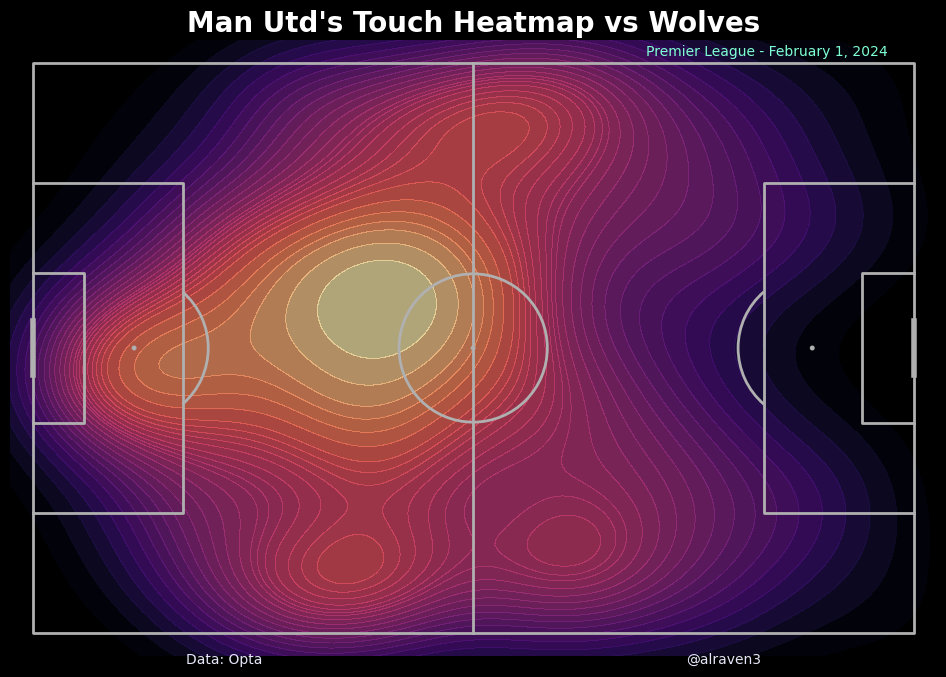

In [32]:
fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#000000')

#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#000000',line_zorder=2)

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=a_passes,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        
        alpha=.7,
        n_levels=30,
        cmap='magma'
)

plt.title(f"{a_team}'s Touch Heatmap vs {h_team}",size=20,color='white',fontweight='bold')
fig.text(0.82,0.86,f"{competition_date}",ha='right',color='aquamarine',size=10)
fig.text(0.67,0.1,'@alraven3',color='lavender',size=10)
fig.text(0.3,0.1,'Data: Opta',color='lavender',size=10)


Text(0.3, 0.1, 'Data: Opta')

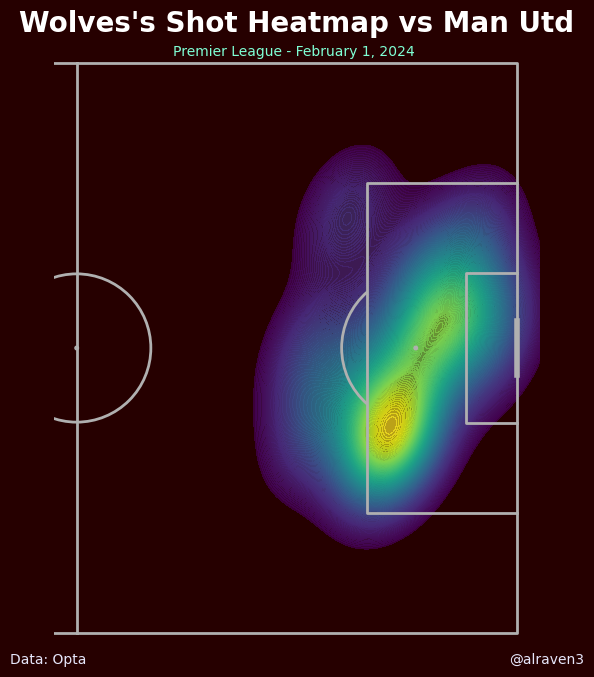

In [33]:
fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#260000')

#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#260000',half=True,line_zorder=2)

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=h_shots,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        alpha=.7,
        n_levels=200,
        cmap='viridis'
)

plt.title(f"{h_team}'s Shot Heatmap vs {a_team}",size=20,fontweight='bold',color='white')
fig.text(0.6,0.86,f"{competition_date}",ha='right',color='aquamarine',size=10)
fig.text(0.67,0.1,'@alraven3',color='lavender',size=10)
fig.text(0.3,0.1,'Data: Opta',color='lavender',size=10)


Text(0.3, 0.1, 'Data: Opta')

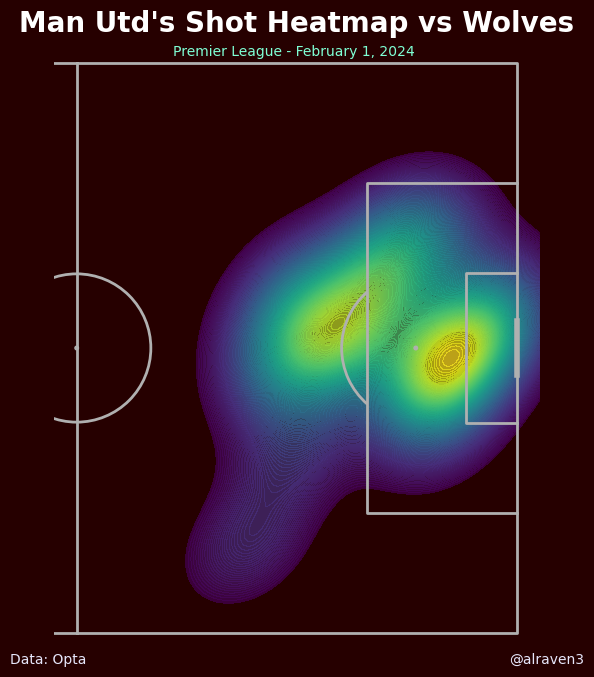

In [34]:
fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#260000')

#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#260000',half=True,line_zorder=2)

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=a_shots,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        alpha=.7,
        n_levels=200,
        cmap='viridis'
)

plt.title(f"{a_team}'s Shot Heatmap vs {h_team}",size=20,fontweight='bold',color='white')
fig.text(0.6,0.86,f"{competition_date}",ha='right',color='aquamarine',size=10)
fig.text(0.67,0.1,'@alraven3',color='lavender',size=10)
fig.text(0.3,0.1,'Data: Opta',color='lavender',size=10)


https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_heatmap.html#sphx-glr-gallery-pitch-plots-plot-heatmap-py

Text(0.2, 0.03, 'Data: Opta')

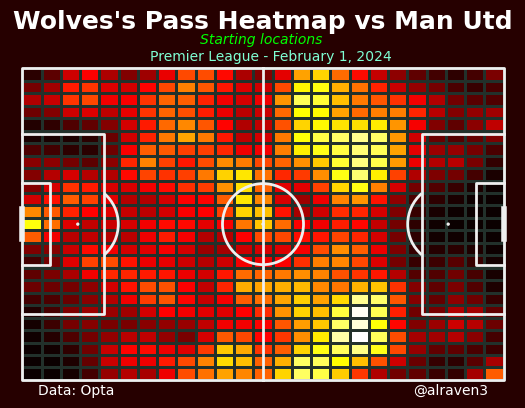

In [35]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='opta', line_zorder=2,
              pitch_color='#260000', line_color='#efefef',pad_top=10)
# draw
fig, ax = pitch.draw(figsize=(7.5, 4.125))
fig.set_facecolor('#260000')
bin_statistic = pitch.bin_statistic(h_passes.x, h_passes.y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
# Add the colorbar and format off-white
#cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
#cbar.outline.set_edgecolor('#efefef')
#cbar.ax.yaxis.set_tick_params(color='#efefef')
#ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

ax_title = ax.set_title(f"{h_team}'s Pass Heatmap vs {a_team}", fontsize=18,color='white',fontweight='bold')
x, y, text = 37, 108, "Starting locations"
ax.text(x, y, text,color='lime',style='italic')
fig.text(0.35, 0.84, f"{competition_date}",color='aquamarine')
fig.text(0.7,0.03,'@alraven3',color='white')
fig.text(0.2,0.03,'Data: Opta',color='white')

Text(0.2, 0.03, 'Data: Opta')

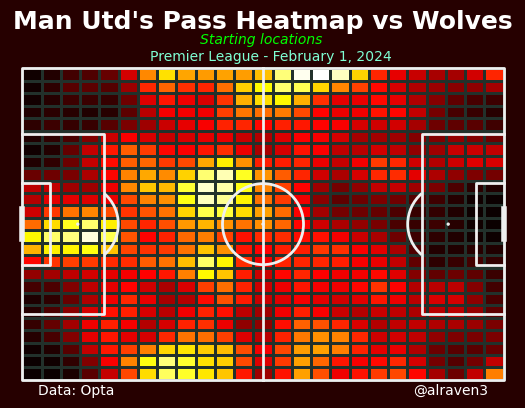

In [36]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='opta', line_zorder=2,
              pitch_color='#260000', line_color='#efefef',pad_top=10)
# draw
fig, ax = pitch.draw(figsize=(7.5, 4.125))
fig.set_facecolor('#260000')
bin_statistic = pitch.bin_statistic(a_passes.x, a_passes.y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
# Add the colorbar and format off-white
#cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
#cbar.outline.set_edgecolor('#efefef')
#cbar.ax.yaxis.set_tick_params(color='#efefef')
#ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

ax_title = ax.set_title(f"{a_team}'s Pass Heatmap vs {h_team}", fontsize=18,color='white',fontweight='bold')
x, y, text = 37, 108, "Starting locations"
ax.text(x, y, text,color='lime',style='italic')
fig.text(0.35, 0.84, f"{competition_date}",color='aquamarine')
fig.text(0.7,0.03,'@alraven3',color='white')
fig.text(0.2,0.03,'Data: Opta',color='white')

Text(0.23, 0.02, 'Data: Opta')

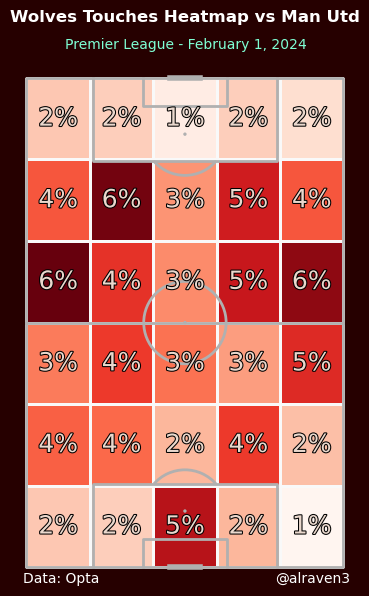

In [37]:
# path effects
import matplotlib.patheffects as path_effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#260000')
bin_statistic = pitch.bin_statistic(h_touches.x, h_touches.y, statistic='count', bins=(6, 5), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#ead8cd', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

ax.set_title(f"{h_team} Touches Heatmap vs {a_team}",color='white',fontweight='bold')
fig.text(0.3, 0.91, f"{competition_date}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='white')
fig.text(0.23,0.02,'Data: Opta',color='white')

Text(0.23, 0.02, 'Data: Opta')

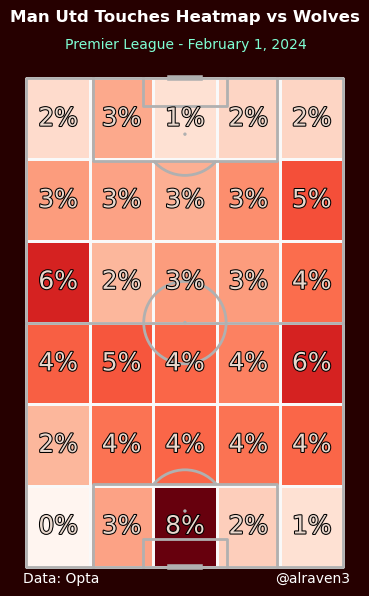

In [38]:
# path effects
import matplotlib.patheffects as path_effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#260000')
bin_statistic = pitch.bin_statistic(a_touches.x, a_touches.y, statistic='count', bins=(6, 5), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#ead8cd', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

ax.set_title(f"{a_team} Touches Heatmap vs {h_team}",color='white',fontweight='bold')
fig.text(0.3, 0.91, f"{competition_date}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='white')
fig.text(0.23,0.02,'Data: Opta',color='white')

Text(0.23, 0.02, 'Data: Opta')

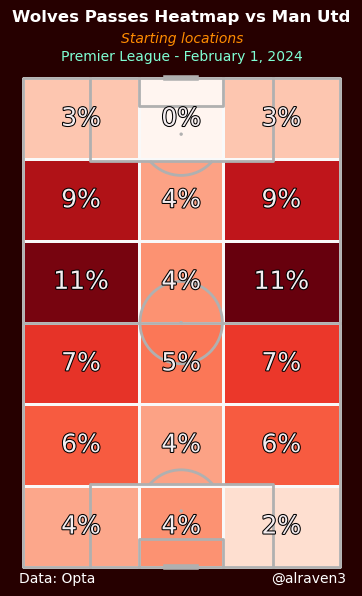

In [39]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#260000')
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))
bin_statistic = pitch.bin_statistic(h_passes.x, h_passes.y, statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels2 = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=ax, ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff)

ax.set_title(f"{h_team} Passes Heatmap vs {a_team}",color='white',fontweight='bold')
fig.text(0.4, 0.92, "Starting locations",color='darkorange',style='italic')
fig.text(0.3, 0.89, f"{competition_date}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='white')
fig.text(0.23,0.02,'Data: Opta',color='white')

Text(0.15, 0.02, 'Data: Opta')

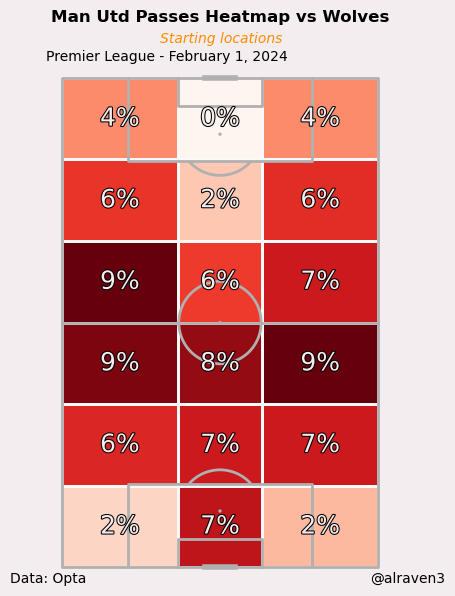

In [40]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#f4edf0',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#f4edf0')
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))
bin_statistic = pitch.bin_statistic(a_passes.x, a_passes.y, statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels2 = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=ax, ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff)

ax.set_title(f"{a_team} Passes Heatmap vs {h_team}",color='black',fontweight='bold')
fig.text(0.4, 0.92, "Starting locations",color='darkorange',style='italic')
fig.text(0.21, 0.89, f"{competition_date}",color='black')
fig.text(0.75,0.02,'@alraven3',color='black')
fig.text(0.15,0.02,'Data: Opta',color='black')

https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_heatmap_positional.html#sphx-glr-gallery-pitch-plots-plot-heatmap-positional-py

Text(0.23, 0.02, 'Data: Opta')

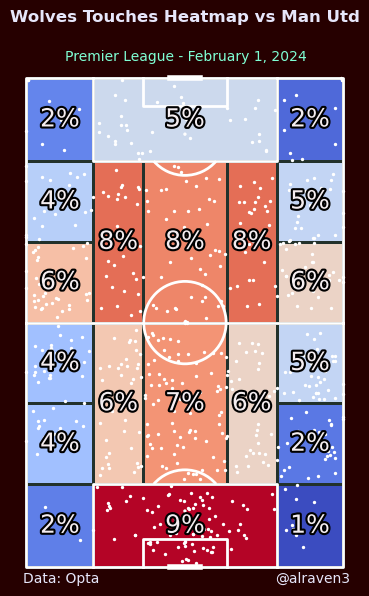

In [41]:
# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

# setup pitch
pitch = VerticalPitch(pitch_type='opta', line_zorder=2,
                      pitch_color='#260000', line_color='white',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#260000')

# draw

bin_statistic = pitch.bin_statistic_positional(h_touches.x, h_touches.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=ax, cmap='coolwarm', edgecolors='#22312b')
pitch.scatter(a_touches.x, a_touches.y, c='white', s=2, ax=ax)
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)
ax.set_title(f"{h_team} Touches Heatmap vs {a_team}",color='lavender',fontweight='bold')
fig.text(0.3, 0.89, f"{competition_date}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='lavender')
fig.text(0.23,0.02,'Data: Opta',color='lavender')

Text(0.23, 0.02, 'Data: Opta')

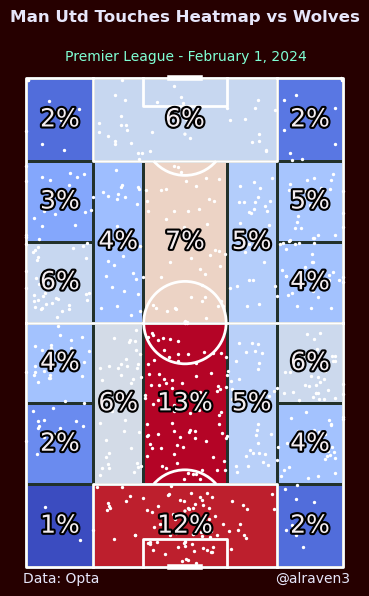

In [42]:
# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

# setup pitch
pitch = VerticalPitch(pitch_type='opta', line_zorder=2,
                      pitch_color='#260000', line_color='white',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#260000')

# draw

bin_statistic = pitch.bin_statistic_positional(a_touches.x, a_touches.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=ax, cmap='coolwarm', edgecolors='#22312b')
pitch.scatter(a_touches.x, a_touches.y, c='white', s=2, ax=ax)
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)
ax.set_title(f"{a_team} Touches Heatmap vs {h_team}",color='lavender',fontweight='bold')
fig.text(0.3, 0.89, f"{competition_date}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='lavender')
fig.text(0.23,0.02,'Data: Opta',color='lavender')

Text(0.23, 0.9, 'Premier League - February 1, 2024')

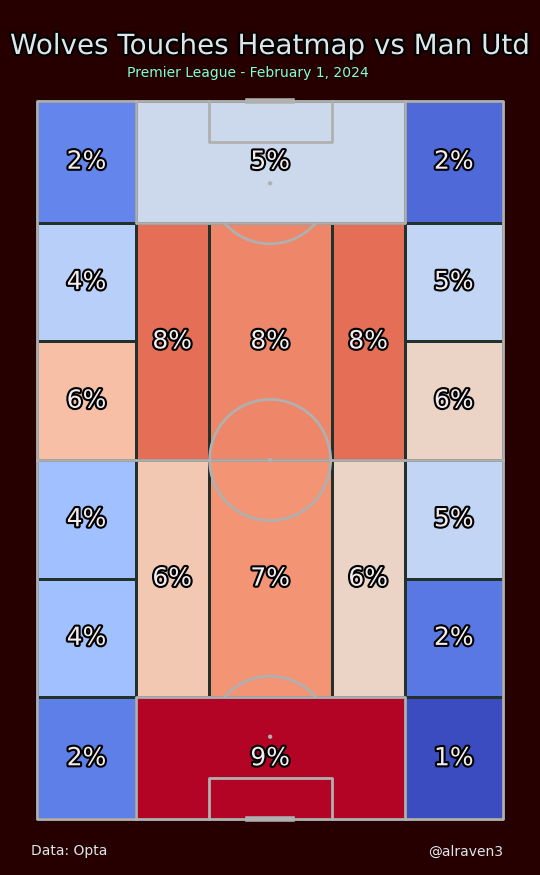

In [43]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#260000')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(h_touches.x, h_touches.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"{h_team} Touches Heatmap vs {a_team}", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=20)
fig.text(0.23, 0.9, f"{competition_date}",color='aquamarine')

Text(0.23, 0.9, 'Premier League - February 1, 2024')

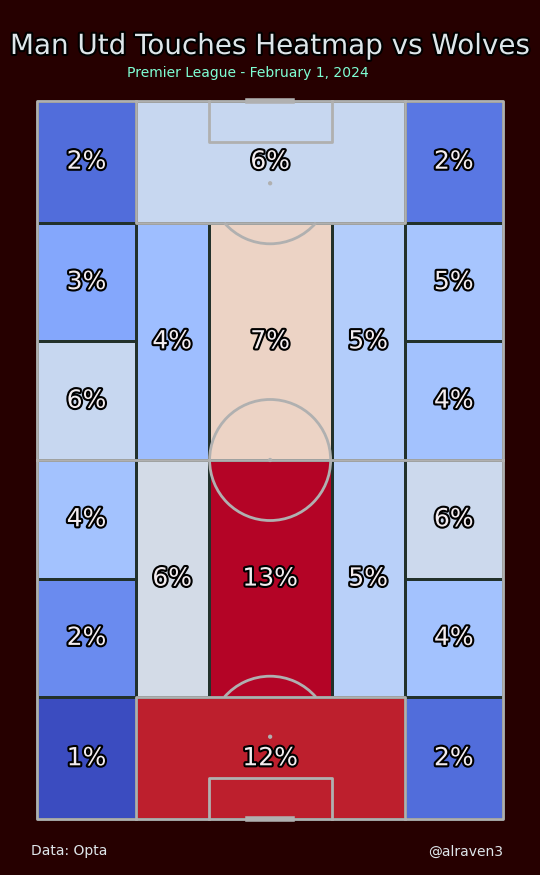

In [44]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#260000')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(a_touches.x, a_touches.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"{a_team} Touches Heatmap vs {h_team}", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=20)
fig.text(0.23, 0.9, f"{competition_date}",color='aquamarine')

More heatmap/colormap customizations: https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_cmap.html#sphx-glr-gallery-pitch-plots-plot-cmap-py

**Pass Networks**

Pass network, based on Karol Działowski: https://www.dzialowski.eu/football-data-visualisations/

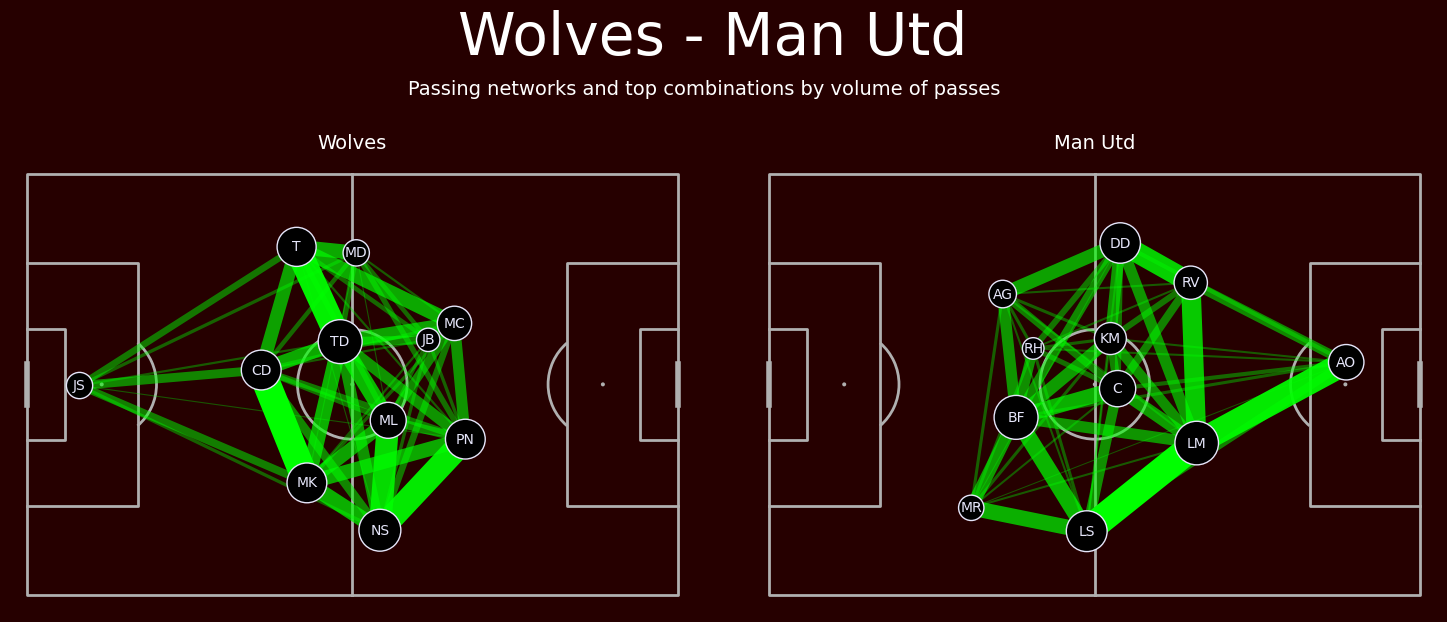

In [45]:
from matplotlib.colors import to_rgba
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#260000")

# plot variables
main_color = 'white'

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
#plt.savefig('output.png', bbox_inches='tight')
plt.show()

Text(0.15, 0.02, 'Data: Opta')

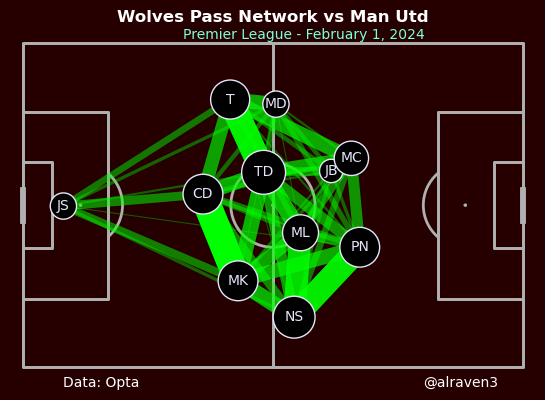

In [46]:
# home team viz
pitch = Pitch(pitch_type="opta", pitch_color='#260000',pad_top=20)
fig, ax = pitch.draw(figsize=(6, 4))
fig.set_facecolor("#260000")
pass_network_visualization(ax,home_passes_between_df, home_average_locs_and_count_df)
ax.set_title(f"{h_team} Pass Network vs {a_team}",color='white',fontweight='bold')
fig.text(0.35, 0.89, f"{competition_date}",color='aquamarine')
fig.text(0.75,0.02,'@alraven3',color='white')
fig.text(0.15,0.02,'Data: Opta',color='white')

Text(0.15, 0.02, 'Data: Opta')

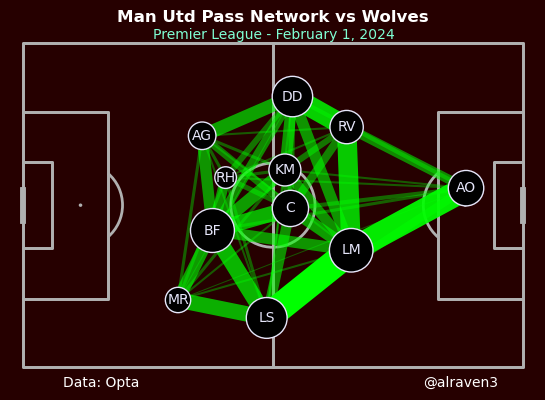

In [47]:
# home team viz
pitch = Pitch(pitch_type="opta", pitch_color='#260000',pad_top=20)
fig, ax = pitch.draw(figsize=(6, 4))
fig.set_facecolor("#260000")
pass_network_visualization(ax,away_passes_between_df, away_average_locs_and_count_df)
ax.set_title(f"{a_team} Pass Network vs {h_team}",color='white',fontweight='bold')
fig.text(0.3, 0.89, f"{competition_date}",color='aquamarine')
fig.text(0.75,0.02,'@alraven3',color='white')
fig.text(0.15,0.02,'Data: Opta',color='white')

https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_pass_network.html

**Team Passmaps Grid**

https://soccermatics.readthedocs.io/en/latest/gallery/lesson1/plot_PlottingPasses.html

*Note: so far I haven't managed to filter out set-piece passes - especially re: throw-ins* (the failed attempts below are about that...)

Text(0.9, 0.03, '@alraven3')

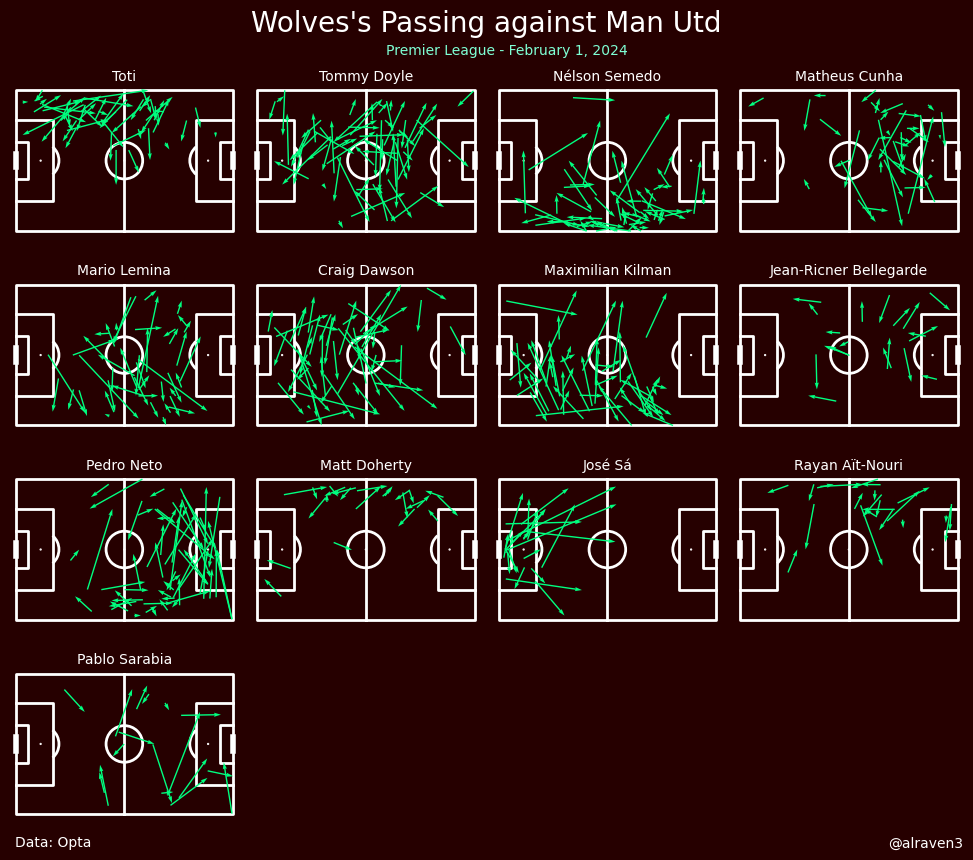

In [48]:
#mask_homePasses = (df.type_name == 'Pass') & (df.team_name == "England Women's") & (df.sub_type_name != "Throw-in")
#home_passes = df.loc[mask_homePasses, ['x', 'y', 'endX', 'endY', 'name']]
#get the list of all players who made a pass
names = h_passes['name'].unique()

#draw 4x4 pitches
pitch = Pitch(pitch_type='opta', line_color='white', pad_top=25, pitch_color='#260000')
fig, axs = pitch.grid(ncols = 4, nrows = 4, grid_height=0.85, title_height=0.03, axis=False,
                     endnote_height=0.01, title_space=0.02, endnote_space=0.01)
fig.set_facecolor("#260000")

#for each player
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put player name over the plot
    ax.text(50, 110, name,
            ha='center', va='center', fontsize=10,color='white')
    #take only passes by this player
    player_df = h_passes.loc[h_passes["name"] == name]
    #scatter
    #pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    #plot arrow
    pitch.arrows(player_df.x, player_df.y,
            player_df.endX, player_df.endY, color = "springgreen", ax=ax, width=1)

#We have more than enough pitches - remove them
for ax in axs['pitch'][-1, 16 - len(names):]:
    ax.remove()

#Another way to set title using mplsoccer
axs['title'].text(0.5, 0.5, f"{h_team}'s Passing against {a_team}", ha='center', va='center', fontsize=20,color='white')
fig.text(0.4,0.91,f"{competition_date}",color='aquamarine')
fig.text(0.03,0.03,"Data: Opta",color='white')
fig.text(0.9,0.03,"@alraven3",color='white')

Text(0.9, 0.03, '@alraven3')

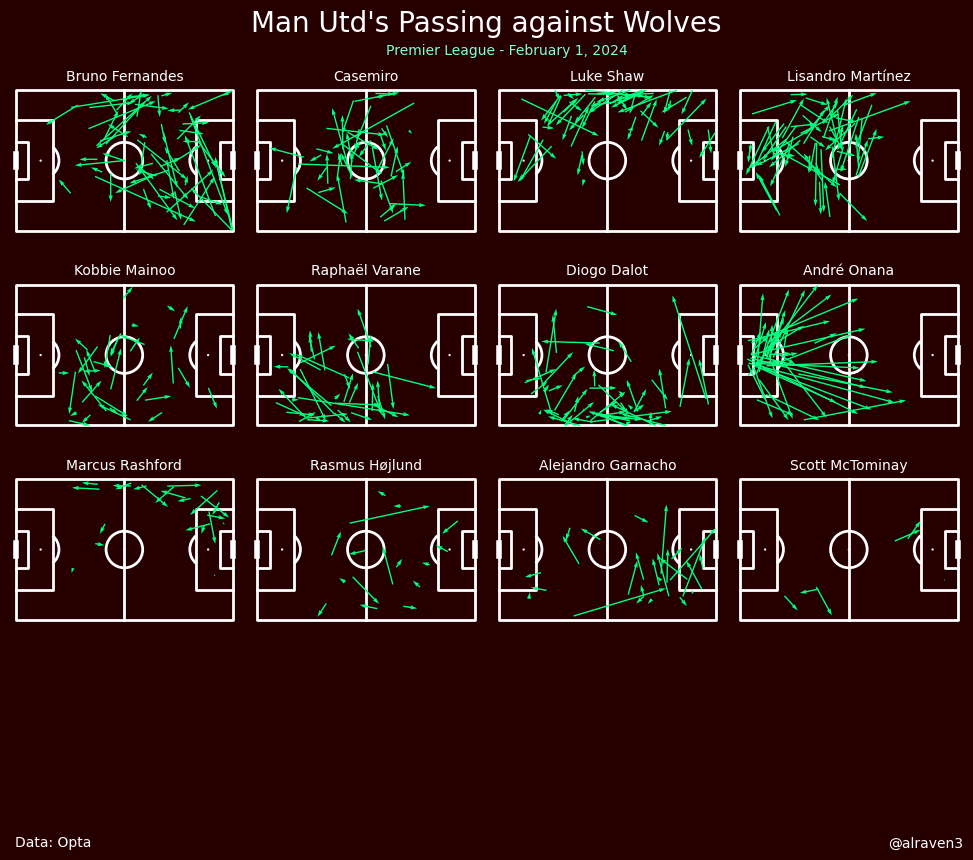

In [49]:
#mask_homePasses = (df.type_name == 'Pass') & (df.team_name == "England Women's") & (df.sub_type_name != "Throw-in")
#home_passes = df.loc[mask_homePasses, ['x', 'y', 'endX', 'endY', 'name']]
#get the list of all players who made a pass
names = a_passes['name'].unique()

#draw 4x4 pitches
pitch = Pitch(pitch_type='opta', line_color='white', pad_top=25, pitch_color='#260000')
fig, axs = pitch.grid(ncols = 4, nrows = 4, grid_height=0.85, title_height=0.03, axis=False,
                     endnote_height=0.01, title_space=0.02, endnote_space=0.01)
fig.set_facecolor("#260000")

#for each player
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put player name over the plot
    ax.text(50, 110, name,
            ha='center', va='center', fontsize=10, color='white')
    #take only passes by this player
    player_df = a_passes.loc[a_passes["name"] == name]
    #scatter
    #pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    #plot arrow
    pitch.arrows(player_df.x, player_df.y,
            player_df.endX, player_df.endY, color = "springgreen", ax=ax, width=1)

#We have more than enough pitches - remove them
for ax in axs['pitch'][-1, 16 - len(names):]:
    ax.remove()

#Another way to set title using mplsoccer
axs['title'].text(0.5, 0.5, f"{a_team}'s Passing against {h_team}", ha='center', va='center', fontsize=20,color='white')
fig.text(0.4,0.91,f"{competition_date}",color='aquamarine')
fig.text(0.03,0.03,"Data: Opta",color='white')
fig.text(0.9,0.03,"@alraven3",color='white')

In [50]:
#h_passes[h_passes['name']=='Clinton Mola']['qualifiers']

In [51]:
#h_passes[h_passes['name']=='Clinton Mola']['qualifiers'][377]

In [52]:
#h_passes.qualifiers

In [53]:
#h_passes2 = h_passes.copy()
#for i in h_passes2['qualifiers']:
#    h_passes2.loc[h_passes2['qualifiers'][i]['displayName']=='ThrowIn']
#h_passes[h_passes['qualifiers']['type']['displayName']=='ThrowIn']

***Unfinished: xT heatmaps/etc....***

In [54]:
#Import xT Grid, turn it into an array, and then get how many rows and columns it has
xT = pd.read_csv("/Users/Al Raven/Documents/Football/xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape
#Bin Data for xT

# We use a pandas method called .cut --> https://pandas.pydata.org/docs/reference/api/pandas.cut.html
# We say labels=False because we want the integer locator of the bin
passes_df['x1_bin'] = pd.cut(passes_df['x'], bins=xT_cols, labels=False)
passes_df['y1_bin'] = pd.cut(passes_df['y'], bins=xT_rows, labels=False)
passes_df['x2_bin'] = pd.cut(passes_df['endX'], bins=xT_cols, labels=False)
passes_df['y2_bin'] = pd.cut(passes_df['endY'], bins=xT_rows, labels=False)

# Return Bin Values for xT
# We use a lambda function to assign the values from the bins to the x and y values with numpy array slicing
# it is going through each row and assigning the values based on where those numbers are in the numpy array
# kind of an advanced topic, so be sure to familiarize yourself with slicing and indexing
# its basically doing this: xT[4][5] where 4 is the fourth list and 5 is the fifth item in that list

passes_df['start_zone_value'] = passes_df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
passes_df['end_zone_value'] = passes_df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)



# now we find the difference between the start and end to get the xT value
passes_df['xT'] = passes_df['end_zone_value'] - passes_df['start_zone_value']

<BarContainer object of 10 artists>

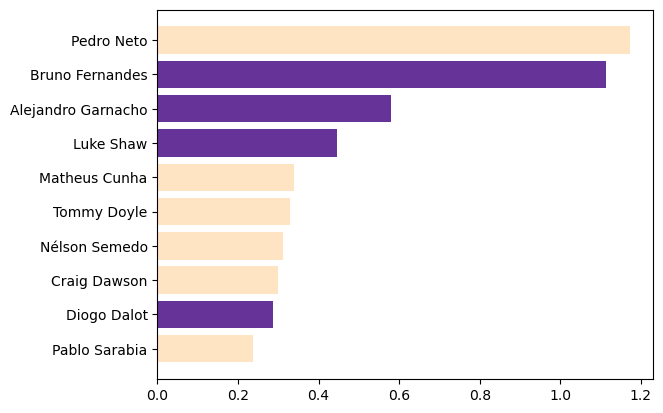

In [55]:
passes_df['playerId'] = passes_df['playerId'].astype('string').str.split('.').str[0]
passes_df['playerId'] = passes_df['playerId'].map(players_ids)
xT_df = passes_df[['teamId','playerId','xT']].copy()
xT_ranking = pd.DataFrame(xT_df.groupby(['teamId','playerId'])['xT'].sum())
xT_ranking = xT_ranking.sort_values('xT',ascending=False)
csv_data = xT_ranking.to_csv('xT_ranking.csv', index = True) 
xT = pd.read_csv('xT_ranking.csv')
xT = xT.replace(to_replace=h_id,value=h_team)
xT = xT.replace(to_replace=a_id,value=a_team)
xT = xT.sort_values("xT",ascending=False)
xT = xT[0:10]
xT = xT.sort_values("xT",ascending=True)
# Define the colors for each team
colors = {h_team: 'bisque', a_team: 'rebeccapurple'}
# Map teamId to colors for the top players
top_colors = xT['teamId'].map(colors)
plt.barh(data=xT, y='playerId',width="xT",color=top_colors)
#alternatively, find the team colors (via hex codes) at https://teamcolorcodes.com/, and replace the above lines
#with the ones below
#palette = {h_team:'#DA291C',a_team:'#132257'}
#plt.barh(data=xT, y='playerId',width="xT",color=palette)

# Event Maps (Players)

**Put the name of the player (+team) whose event maps (passes, carries, shots,etc.) you want to create/see**  
Note that for carries and progressive carries, you first have to create the data in the above *Creating Carries and Progressive Carries Data* section; if you don't want to see the carries, then you can just proceed below...

In [56]:
player_name='Bruno Fernandes'
player_team = 'Manchester Utd'

In [57]:
player_df = df1.loc[df1['name']==player_name].copy()
player_passes = player_df.loc[player_df['type_displayName']=='Pass'].copy()
#passes IN opponent's half
player_opphalf_passes = player_passes[player_passes['x']>=50]
#passes in their own half
player_ownhalf_passes = player_passes[player_passes['x']<50]
#passes INTO the final third
player_final_3rd_passes = player_passes[player_passes['endX']>=66]
player_final_3rd_passes = player_final_3rd_passes[player_final_3rd_passes['x']<=66]
#completed passes into the final third
player_comp_final3rd_passes = player_final_3rd_passes[player_final_3rd_passes['outcomeType_displayName']=='Successful']
#passes into the opponent's box
#player_passes_intobox = player_passes[player_passes['endX']>=85]
#player_passes_intobox = player_passes_intobox[player_passes_intobox['endY']<=80]
#player_passes_intobox = player_passes_intobox[player_passes_intobox['endY']>=20]
player_passes_intobox = player_passes[((player_passes['endX']>=85)&(player_passes['x']<85)&(player_passes['endY']>=20)&(player_passes['endY']<=80))|
                           ((player_passes['endX']>=85)&(player_passes['x']>85)&(player_passes['endY']>=20)&(player_passes['endY']<=80)
                            &(player_passes['y']>80)&(player_passes['y']<20))]
#player_passes_intobox = player_passes_intobox[player_passes_intobox['x']<82.9]
#completed/successful passes into the opponent's box
player_comp_passes_intobox = player_passes_intobox[player_passes_intobox['outcomeType_displayName']=='Successful']

#take-ons/dribbles
player_dribbles = player_df.loc[player_df['type_displayName']=='TakeOn'].copy()
#touches
player_touches = player_df.loc[player_df['isTouch']==True].copy()
player_touches2 = player_df.loc[player_df['type_displayName']=='BallTouch'].copy()
#dispossessions
player_dispossessions = player_df.loc[player_df['type_displayName']=='Dispossessed'].copy()
#shots
player_shots = player_df.loc[player_df['isShot']==True].copy()
#goals
player_goals = player_df.loc[player_df['isGoal']==True].copy()
#tackles
player_tackles = player_df.loc[player_df.type_displayName=='Tackle'].copy()
#challenges
player_challenges = player_df.loc[player_df.type_displayName=='Challenge'].copy()
#clearances
player_clearances = player_df.loc[player_df.type_displayName=='Clearance'].copy()
#recoveries
player_recoveries = player_df.loc[player_df.type_displayName=='BallRecovery'].copy()
#blocked passes
player_blocked_passes = player_df.loc[player_df.type_displayName=='BlockedPass'].copy()
#interceptions
player_interceptions = player_df.loc[player_df.type_displayName=='Interception'].copy()
#aerial duels
player_aerials = player_df.loc[player_df['type_displayName']=='Aerial'].copy()
#all defensive actions: 
player_defensive_actions = player_df.loc[(player_df.type_displayName=='Challenge') |  
        (player_df.type_displayName=='BlockedPass')|
        (player_df.type_displayName=='Tackle')|
        (player_df.type_displayName=='Interception')|
        (player_df.type_displayName=='Aerial')|
        (player_df.type_displayName=='Foul')].copy()
player_passes['beginning'] = np.sqrt(np.square(100 - player_passes['x']) + np.square(50 - player_passes['y']))
player_passes['end'] = np.sqrt(np.square(100 - player_passes['endX']) + np.square(50 - player_passes['endY']))
player_passes.loc[:, 'progressive'] = (player_passes['end'] / player_passes['beginning'] < 0.75) & (player_passes['x']<player_passes['endX'])
player_progressive_passes = player_passes[player_passes['progressive']==True]

Text(0.3, 0.1, 'Data: Opta')

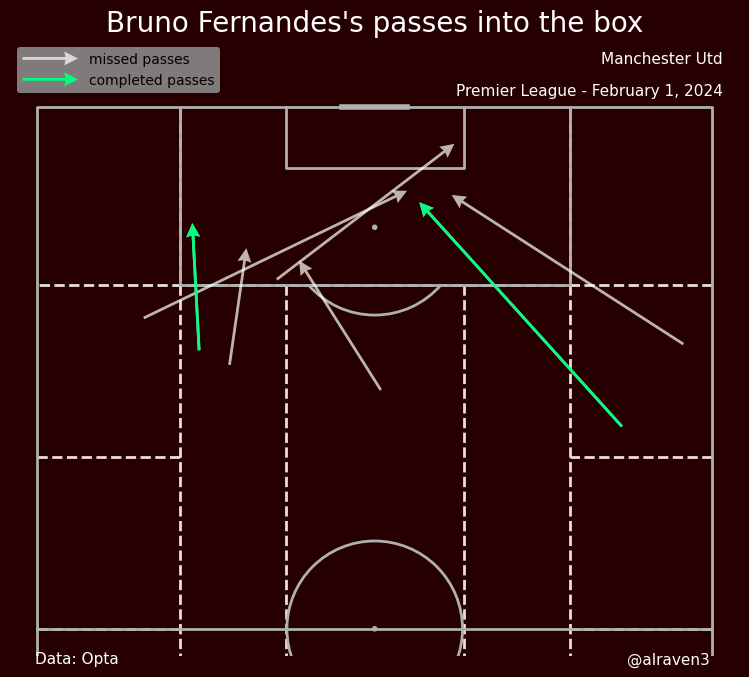

In [58]:
pitch = VerticalPitch(positional=True, pitch_type='opta', half=True, 
                      pitch_color='#260000', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.arrows(player_passes_intobox.x, player_passes_intobox.y,
             player_passes_intobox.endX, player_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='white',alpha=.7, label='missed passes',ax=ax)
pitch.arrows(player_comp_passes_intobox.x, player_comp_passes_intobox.y,
             player_comp_passes_intobox.endX, player_comp_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='springgreen', label='completed passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f"{player_name}'s passes into the box", fontsize=20,color='white')
fig.text(0.73,0.85,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.73,0.81,f"{competition_date}",ha='right',color='white',size=11)
fig.text(0.67,0.1,'@alraven3',color='white',size=11)
fig.text(0.3,0.1,'Data: Opta',color='white',size=11)

Text(0.28, 0.1, 'Data: Opta')

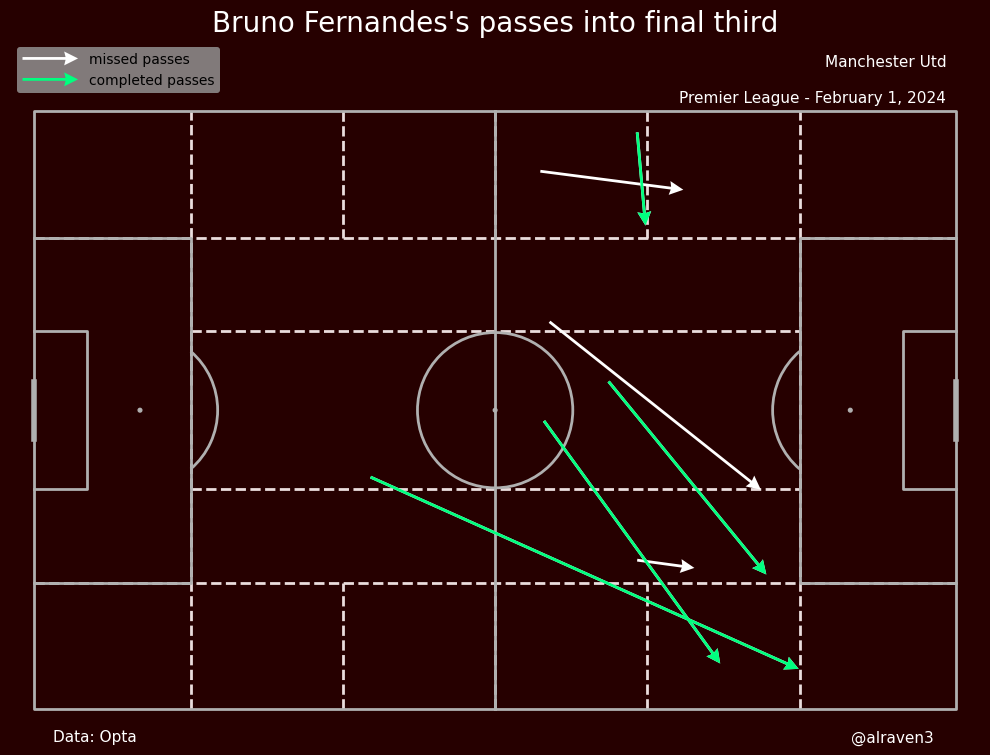

In [59]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#260000', positional_linestyle='--',pad_top=12)
fig, ax = pitch.draw(figsize=(19, 9), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
# Plot the completed passes
pitch.arrows(player_final_3rd_passes.x, player_final_3rd_passes.y,
             player_final_3rd_passes.endX, player_final_3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='white', label='missed passes',ax=ax)
pitch.arrows(player_comp_final3rd_passes.x, player_comp_final3rd_passes.y,
             player_comp_final3rd_passes.endX, player_comp_final3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='springgreen', label='completed passes', ax=ax)
ax.legend(facecolor='#999999', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f"{player_name}'s passes into final third", fontsize=20,color='white')
fig.text(0.75,0.85,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.75,0.81,f"{competition_date}",ha='right',color='white',size=11)
fig.text(0.7,0.1,'@alraven3',color='white',size=11)
fig.text(0.28,0.1,'Data: Opta',color='white',size=11)

Text(0.18, 0.1, 'Data: Opta')

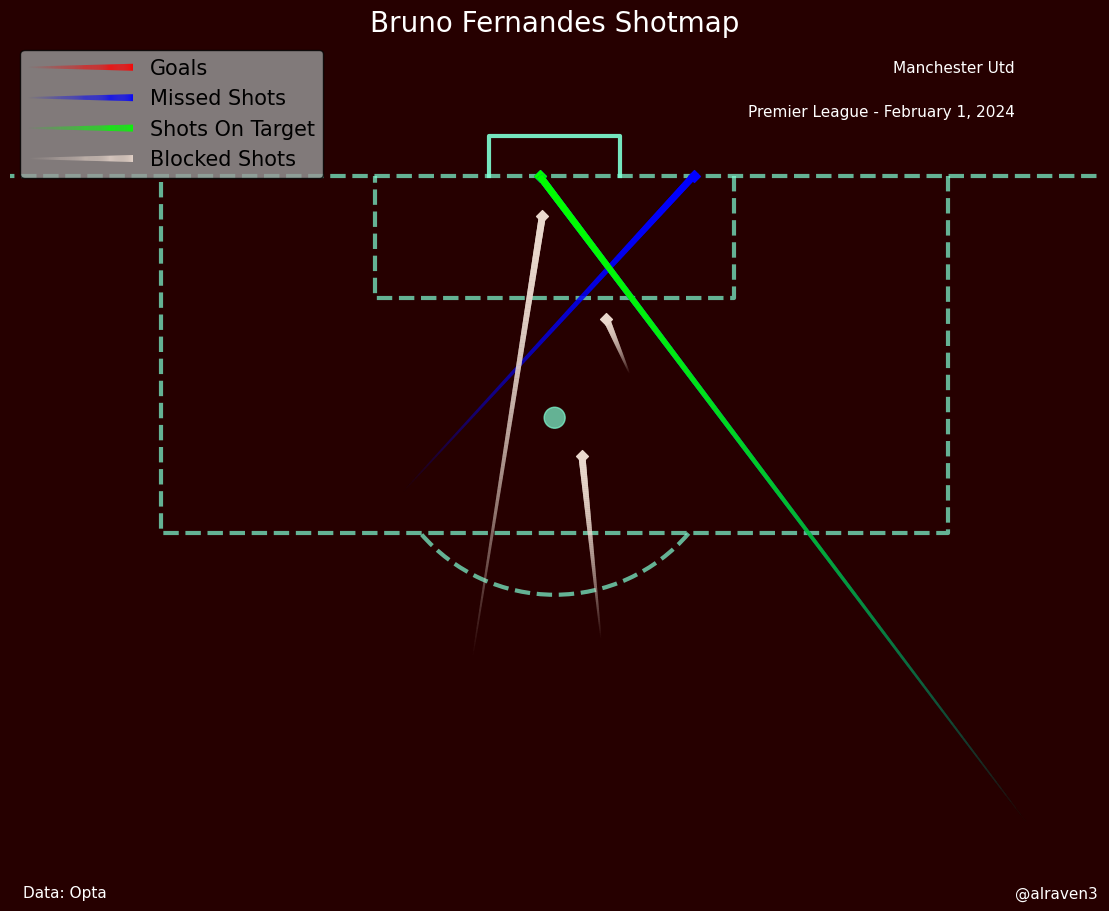

In [60]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#260000', half=True,
                      pad_left=-10,pad_right=-10,pad_top=10,pad_bottom=-25,
                      spot_scale=0.005,linewidth=3,line_alpha=0.7, goal_alpha=0.9,
                      goal_type='box',linestyle='--',line_color='aquamarine')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

df_missed_shots = df1.loc[df1['type_displayName']=='MissedShots']
player_missed = df_missed_shots.loc[df_missed_shots['name']==player_name]
# Update 'endX' column for unblocked shots
player_shots.loc[player_shots['blockedX'].isna(), 'endX'] = 100
player_goals.loc[player_goals['blockedX'].isna(), 'endX'] = 100
player_missed.loc[player_missed['blockedX'].isna(), 'endX'] = 100

# Differentiate between blocked shots, goals, on-target shots, and missed shots
player_shots['on_target'] = np.where((player_shots['endX'] >= 100) & (player_shots['goalMouthY'] >= 45) & (player_shots['goalMouthY'] <= 55), True, False)
player_shots['missed'] = ~player_shots['on_target']

# Plot goals as red arrows
pitch.scatter(player_goals['endX'], player_goals['goalMouthY'],marker='D',color='red',ax=ax)
pitch.lines(player_goals['x'], player_goals['y'], player_goals['endX'], player_goals['goalMouthY'], comet=True,
            transparent=True, color='red', label='Goals',ax=ax)

# Plot missed shots (off target) as blue arrows
#missed_shots = h_shots[(h_shots['missed']) & (h_shots['isGoal'] != 1)]
pitch.scatter(player_missed.endX,player_missed.goalMouthY,color='blue',marker='D',ax=ax)
#pitch.arrows(missed_shots['x'], missed_shots['y'], missed_shots['endX'], missed_shots['goalMouthY'],
#             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)
pitch.lines(player_missed.x,player_missed.y,player_missed.endX,player_missed.goalMouthY,
             comet=True, transparent=True, color='blue', label='Missed Shots', ax=ax)

# Plot on-target shots as green arrows (excluding goals)
on_target_shots = player_shots[(player_shots['on_target']) & (player_shots['isGoal'] != 1)]
pitch.scatter(on_target_shots['endX'], on_target_shots['goalMouthY'],color='lime',marker='D',ax=ax)
pitch.lines(on_target_shots['x'], on_target_shots['y'], on_target_shots['endX'], on_target_shots['goalMouthY'],
             comet=True, transparent=True,  color='lime', label='Shots On Target', ax=ax)

# Plot blocked shots as black arrows
blocked_shots = player_shots[player_shots['blockedX'].notna()]
#pitch.scatter(blocked_shots['x'], blocked_shots['y'],color='black',ax=ax)
pitch.scatter(blocked_shots['blockedX'], blocked_shots['blockedY'],marker='D',color='#ead8cd',ax=ax)
pitch.lines(blocked_shots['x'], blocked_shots['y'], blocked_shots['blockedX'], blocked_shots['blockedY'],
             comet=True, transparent=True, color='#ead8cd', label='Blocked Shots',ax=ax)
#title
fig.set_facecolor('#260000')
ax_title = ax.set_title(f"{player_name} Shotmap", fontsize=20,color='white')

# Add a legend to the plot
ax.legend(facecolor='#999999', edgecolor='black',labelcolor='black',fontsize=15,loc='upper left', handlelength=5)
fig.text(0.8,0.85,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.8,0.81,f"{competition_date}",ha='right',color='white',size=11)
fig.text(0.8,0.1,'@alraven3',color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

Text(0.18, 0.1, 'Data: Opta')

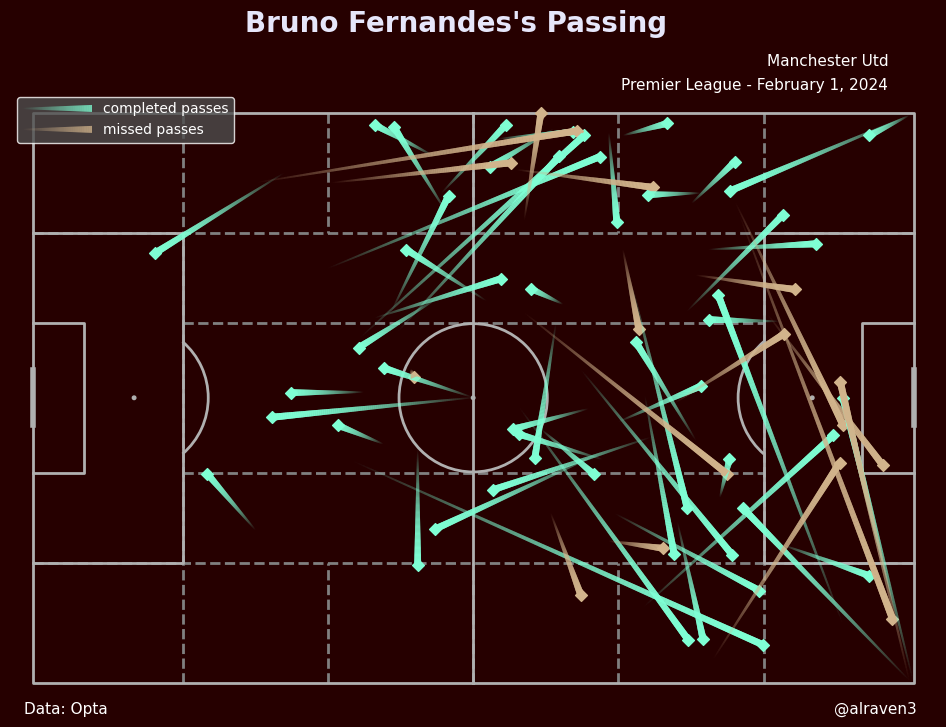

In [61]:
player_successfulPasses = player_passes[player_passes['outcomeType_displayName']=='Successful']
player_otherPasses = player_passes[player_passes['outcomeType_displayName']=='Unsuccessful']
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', positional_linestyle='--', 
              shade_color='#4d4d4d', pitch_color='#260000')
fig, ax = pitch.draw(figsize=(13.5, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
pitch.scatter(player_successfulPasses.endX, player_successfulPasses.endY,color='aquamarine',marker='D',ax=ax)
pitch.lines(player_successfulPasses.x, player_successfulPasses.y,
             player_successfulPasses.endX, player_successfulPasses.endY, 
            comet=True, transparent=True, color='aquamarine', label='completed passes',ax=ax)
pitch.scatter(player_otherPasses.endX, player_otherPasses.endY,color='tan',marker='D',ax=ax)
pitch.lines(player_otherPasses.x, player_otherPasses.y,
             player_otherPasses.endX, player_otherPasses.endY, 
            comet=True, transparent=True, color='tan', label='missed passes', ax=ax)
ax.legend(facecolor='#4d4d4d', edgecolor='white',fontsize=10, labelcolor='white',loc='upper left', handlelength=5)
plt.suptitle(f"{player_name}'s Passing",size=20,color='lavender',fontweight='bold')
fig.text(0.82,0.91,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.82,0.88,f"{competition_date}",ha='right',color='white',size=11)
fig.text(0.78,0.1,'@alraven3',color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)


Text(0.18, 0.1, 'Data: Opta')

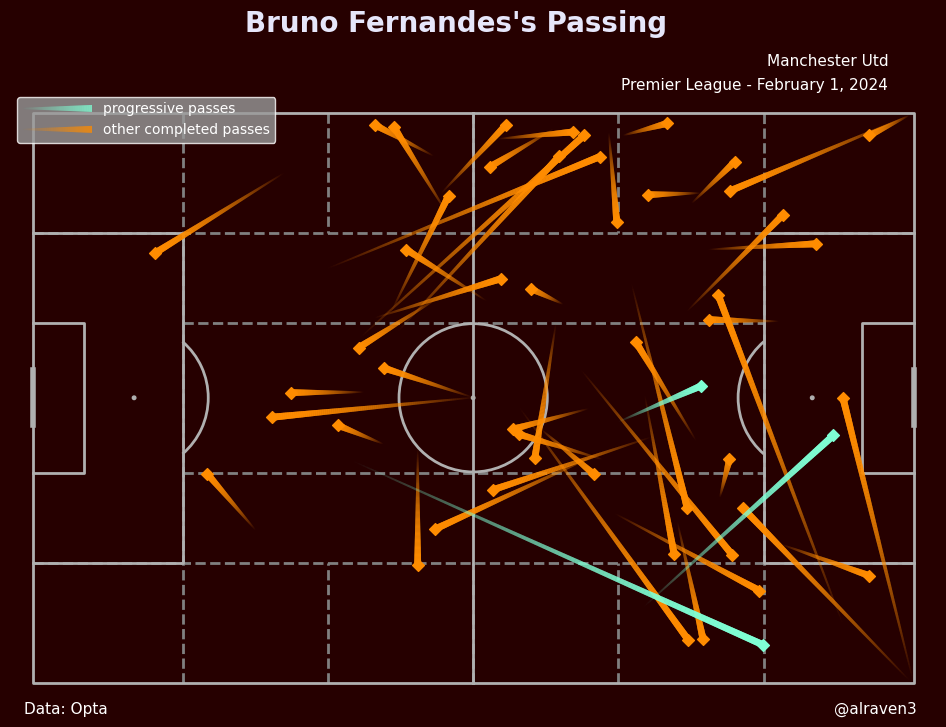

In [62]:
player_prog_passes = player_successfulPasses[player_successfulPasses['progressive']==True]
other_passes = player_successfulPasses[player_successfulPasses['progressive']==False]
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', 
              positional_linestyle='--', pitch_color='#260000')
fig, ax = pitch.draw(figsize=(13.5, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
pitch.scatter(player_prog_passes.endX, player_prog_passes.endY,color='aquamarine',marker='D',zorder=3,ax=ax)
pitch.lines(player_prog_passes.x, player_prog_passes.y,
             player_prog_passes.endX, player_prog_passes.endY,
             comet=True, transparent=True,label='progressive passes',color='aquamarine', zorder=3,ax=ax)
pitch.scatter(other_passes.endX, other_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(other_passes.x, other_passes.y,
             other_passes.endX, other_passes.endY,
             comet=True, transparent=True,color='darkorange',label='other completed passes',ax=ax)
ax.legend(facecolor='#999999', edgecolor='white',labelcolor='white',fontsize=10,loc='upper left', handlelength=5)
plt.suptitle(f"{player_name}'s Passing",size=20,color='lavender',fontweight='bold')
fig.text(0.82,0.91,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.82,0.88,f"{competition_date}",ha='right',color='white',size=11)
fig.text(0.78,0.1,'@alraven3',color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

Text(0.18, 0.1, 'Data: Opta')

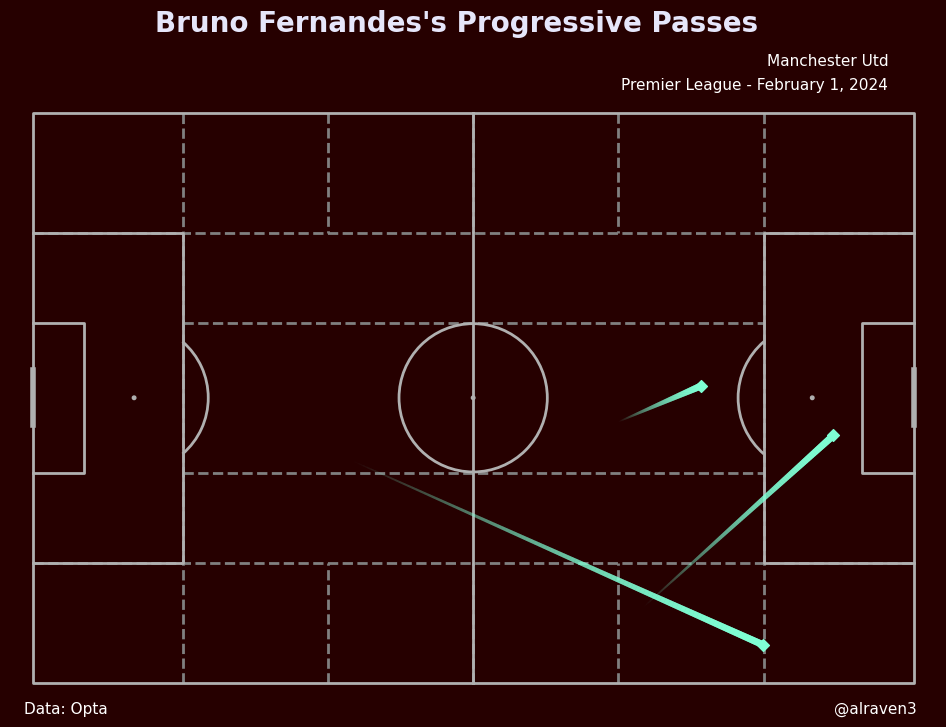

In [63]:
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', 
              positional_linestyle='--', pitch_color='#260000')
fig, ax = pitch.draw(figsize=(13.5, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
pitch.scatter(player_prog_passes.endX, player_prog_passes.endY,color='aquamarine',marker='D',zorder=3,ax=ax)
pitch.lines(player_prog_passes.x, player_prog_passes.y,
             player_prog_passes.endX, player_prog_passes.endY,
             comet=True, transparent=True,label='progressive passes',color='aquamarine', zorder=3,ax=ax)
plt.suptitle(f"{player_name}'s Progressive Passes",size=20,color='lavender',fontweight='bold')
fig.text(0.82,0.91,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.82,0.88,f"{competition_date}",ha='right',color='white',size=11)
fig.text(0.78,0.1,'@alraven3',color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

Text(0.2, 0.02, 'Data: Opta')

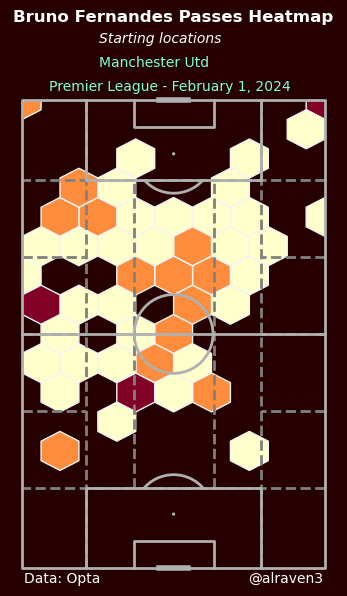

In [64]:
pitch = VerticalPitch(positional=True,pitch_type='opta', positional_color='grey', 
                      positional_linestyle='--', line_zorder=2,positional_zorder=1.5,
                      pitch_color='#260000',pad_top=23)
fig, ax = pitch.draw(figsize=(5, 6))
fig.set_facecolor('#260000')

hexmap = pitch.hexbin(player_passes.x, player_passes.y, ax=ax, edgecolors='#f4f4f4',
                      gridsize=(8, 8), cmap='YlOrRd')
ax.set_title(f"{player_name} Passes Heatmap",color='white',fontweight='bold')
fig.text(0.35, 0.92, "Starting locations",color='white',style='italic')
fig.text(0.25, 0.84, f"{competition_date}",color='aquamarine')
fig.text(0.35, 0.88, f"{player_team}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='white')
fig.text(0.2,0.02,'Data: Opta',color='white')

Text(0.04, 0.03, 'Data: Opta')

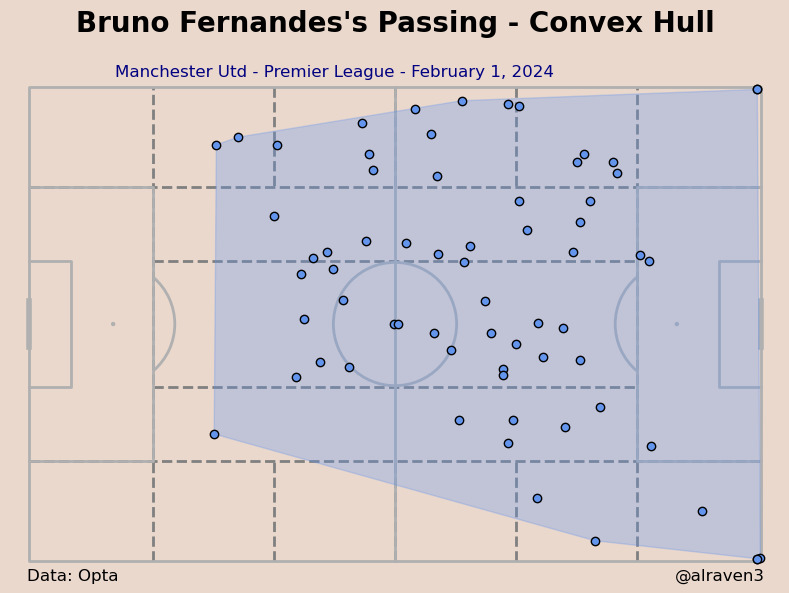

In [65]:
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', 
              positional_linestyle='--', pitch_color='#ead8cd',pad_top=10)
fig, ax = pitch.draw(figsize=(8, 6))
fig.set_facecolor('#ead8cd')
hull = pitch.convexhull(player_passes.x, player_passes.y)
poly = pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
scatter = pitch.scatter(player_passes.x, player_passes.y, ax=ax, edgecolor='black', facecolor='cornflowerblue')
ax_title = ax.set_title(f"{player_name}'s Passing - Convex Hull", fontsize=20, color='black',fontweight='bold')
fig.text(0.15, 0.87, f"{player_team} - {competition_date}",color='navy',size=12)
fig.text(0.85,0.03,'@alraven3',color='black',size=12)
fig.text(0.04,0.03,'Data: Opta',color='black',size=12)

Text(0.88, 0.3, 'Data: Opta')

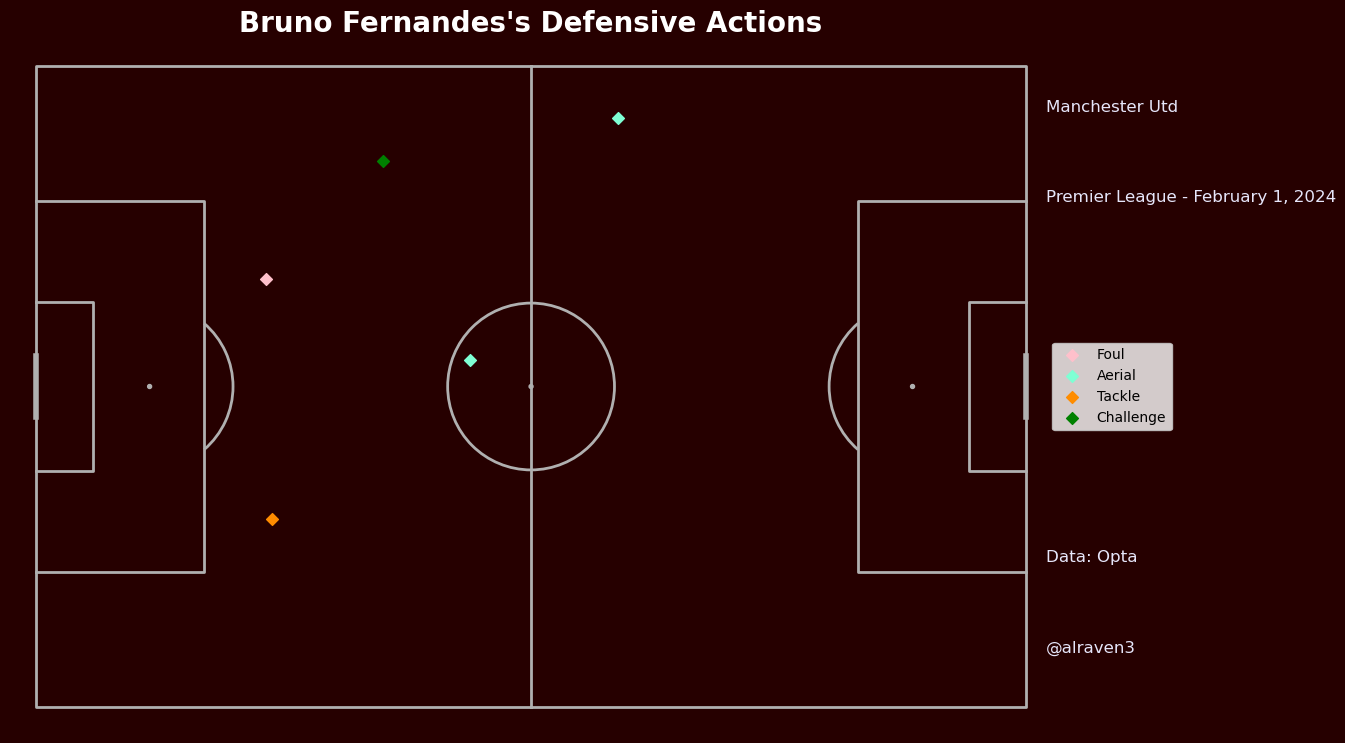

In [66]:
# Define a dictionary for action types and colors
action_colors = {
    'BlockedPass': 'yellow',
    'Interception': 'lime',
    'Foul': 'pink',
    'Aerial': 'aquamarine',
    'Tackle': 'darkorange',
    'Challenge': 'green', 
}

# Initialize the pitch
pitch = Pitch(pitch_type='opta', pitch_color='#260000')
fig, ax = pitch.draw(figsize=(14, 9), constrained_layout=True, tight_layout=False)

# Iterate over action types and plot
for action_type, color in action_colors.items():
    action_data = player_defensive_actions[player_defensive_actions['type_displayName'] == action_type]
    if not action_data.empty:
        pitch.scatter(action_data.x, action_data.y, color=color, label=action_type,marker='D',ax=ax)

# Legend and title
#ax.legend(facecolor='#ead8cd', edgecolor='black', labelcolor='black', fontsize=12, loc='upper right', handlelength=5)
#fig.legend(facecolor='#ead8cd', edgecolor='black', labelcolor='black', fontsize=12, loc='outside upper right', handlelength=5)
plt.legend(bbox_to_anchor=(1, .5), loc='center left', borderaxespad=0)
fig.set_facecolor('#260000')
ax_title = ax.set_title(f"{player_name}'s Defensive Actions", fontsize=20, color='white',fontweight='bold')
fig.text(0.88, 0.8, f"{player_team}",color='lavender',size=12)
fig.text(0.88, 0.7, f"{competition_date}",color='lavender',size=12)
fig.text(0.88,0.2,'@alraven3',color='lavender',size=12)
fig.text(0.88,0.3,'Data: Opta',color='lavender',size=12)


Text(0.18, 0.1, 'Data: Opta')

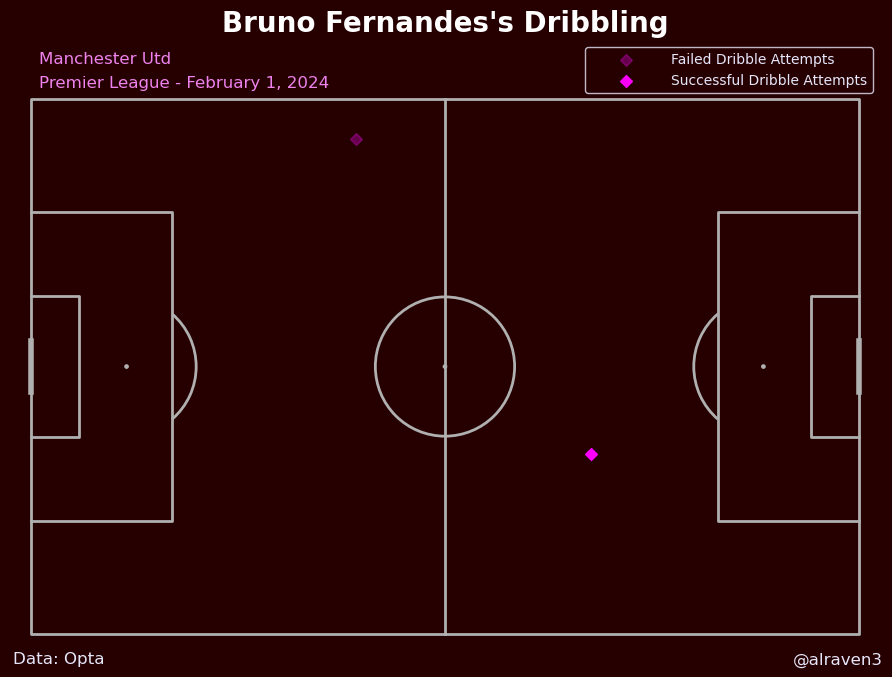

In [67]:
# Initialize the pitch
pitch = Pitch(pitch_type='opta', pitch_color='#260000',pad_top=11)
fig, ax = pitch.draw(figsize=(13, 8), constrained_layout=True, tight_layout=False)

player_unsuccessful_dribbles = player_dribbles.loc[player_dribbles['outcomeType_displayName']=='Unsuccessful'].copy()
player_successful_dribbles = player_dribbles.loc[player_dribbles['outcomeType_displayName']=='Successful'].copy()
pitch.scatter(player_unsuccessful_dribbles.x, player_unsuccessful_dribbles.y, 
              marker='D',color='#ff00ff',alpha=.3,label='Failed Dribble Attempts',ax=ax)
pitch.scatter(player_successful_dribbles.x, player_successful_dribbles.y, 
              marker='D',color='#ff00ff',label='Successful Dribble Attempts',ax=ax)
# Legend and title
ax.legend(facecolor='#260000', edgecolor='lavender', labelcolor='lavender', fontsize=10, loc='upper right', handlelength=5)
fig.set_facecolor('#260000')
ax_title = ax.set_title(f"{player_name}'s Dribbling", fontsize=20, color='white',fontweight='bold')
fig.text(0.2, 0.85, f"{player_team}",color='violet',size=12)
fig.text(0.2, 0.82, f"{competition_date}",color='violet',size=12)
fig.text(0.78,0.1,'@alraven3',color='lavender',size=12)
fig.text(0.18,0.1,'Data: Opta',color='lavender',size=12)

Text(0.19, 0.1, 'Data: Opta')

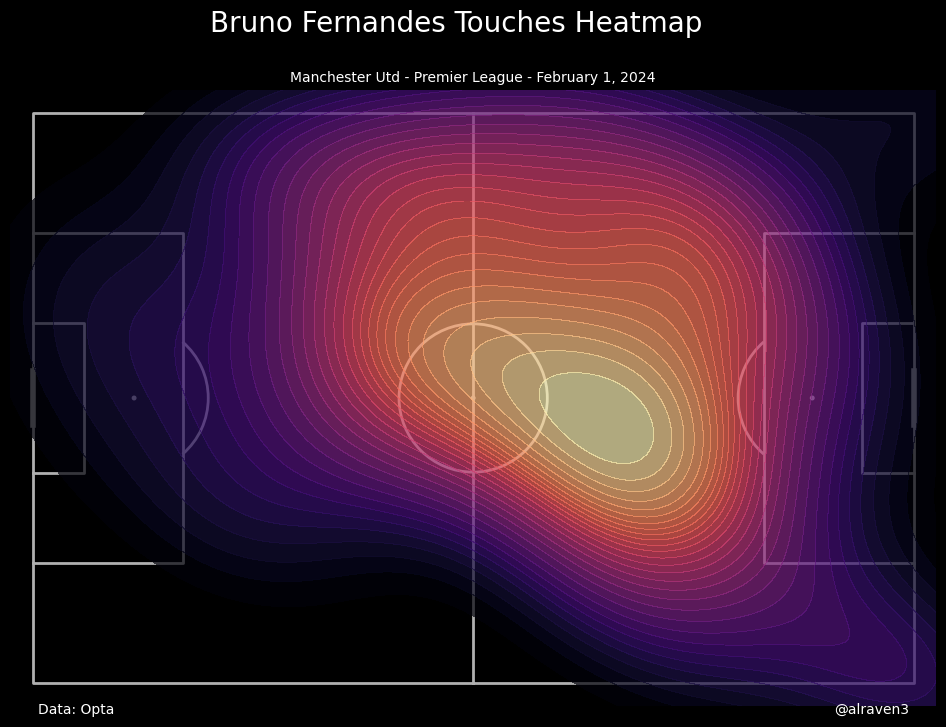

In [68]:
fig ,ax = plt.subplots(figsize=(13.5,8))

#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#000000')

fig.set_facecolor('#000000')

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=player_touches,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        
        alpha=.7,
        n_levels=30,
        cmap='magma'
)

plt.suptitle(f"{player_name} Touches Heatmap",size=20,color='white')
plt.title(f"{player_team} - {competition_date}",size=10,color='white')
fig.text(0.78,0.1,'@alraven3',color='white')
fig.text(0.19,0.1,'Data: Opta',color='white')

Text(0.2, 0.05, 'Data: Opta')

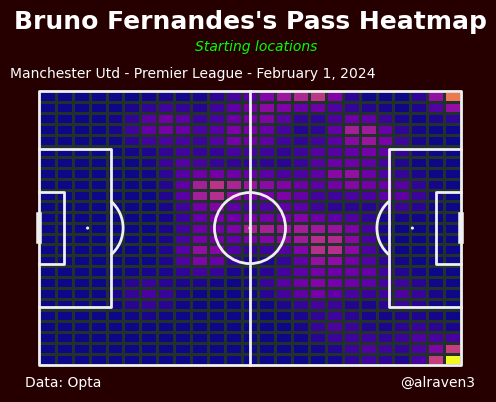

In [69]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='opta', line_zorder=2,
              pitch_color='#260000', line_color='#efefef',pad_top=20,pad_bottom=10)
# draw
fig, ax = pitch.draw(figsize=(7.5, 4.125))
fig.set_facecolor('#260000')
bin_statistic = pitch.bin_statistic(player_passes.x, player_passes.y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='plasma', edgecolors='#22312b')
# Add the colorbar and format off-white
#cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
#cbar.outline.set_edgecolor('#efefef')
#cbar.ax.yaxis.set_tick_params(color='#efefef')
#ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
ax_title = ax.set_title(f"{player_name}'s Pass Heatmap", fontsize=18,color='white',fontweight='bold')
x, y, text = 37, 115, "Starting locations"
ax.text(x, y, text,color='lime',style='italic')
fig.text(0.18, 0.8, f"{player_team} - {competition_date}",color='white')
fig.text(0.7,0.05,'@alraven3',color='white')
fig.text(0.2,0.05,'Data: Opta',color='white')

Text(0.23, 0.02, 'Data: Opta')

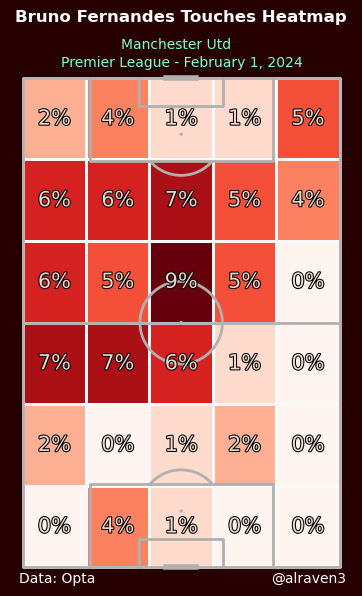

In [70]:
# path effects
import matplotlib.patheffects as path_effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#260000')
bin_statistic = pitch.bin_statistic(player_touches.x, player_touches.y, statistic='count', bins=(6, 5), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#ead8cd', fontsize=15,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)
ax.set_title(f"{player_name} Touches Heatmap",color='white',fontweight='bold')
fig.text(0.4, 0.91, f"{player_team}",color='aquamarine')
fig.text(0.3, 0.88, f"{competition_date}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='white')
fig.text(0.23,0.02,'Data: Opta',color='white')

Text(0.23, 0.02, 'Data: Opta')

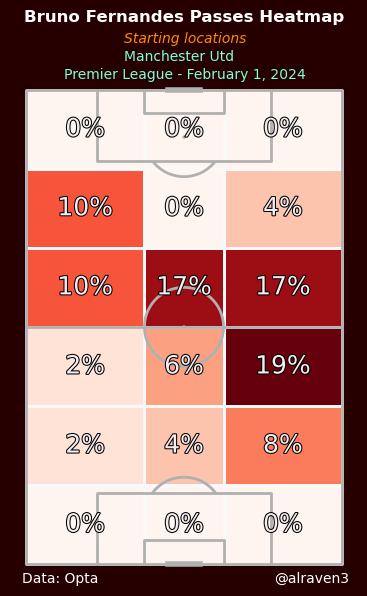

In [71]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#260000',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#260000')
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))
bin_statistic = pitch.bin_statistic(player_passes.x, player_passes.y, statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels2 = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=ax, ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff)
ax.set_title(f"{player_name} Passes Heatmap",color='white',fontweight='bold')
fig.text(0.4, 0.92, "Starting locations",color='darkorange',style='italic')
fig.text(0.4, 0.89, f"{player_team}",color='aquamarine')
fig.text(0.3, 0.86, f"{competition_date}",color='aquamarine')
fig.text(0.65,0.02,'@alraven3',color='white')
fig.text(0.23,0.02,'Data: Opta',color='white')

Text(0.15, 0.9, 'Manchester Utd - Premier League - February 1, 2024')

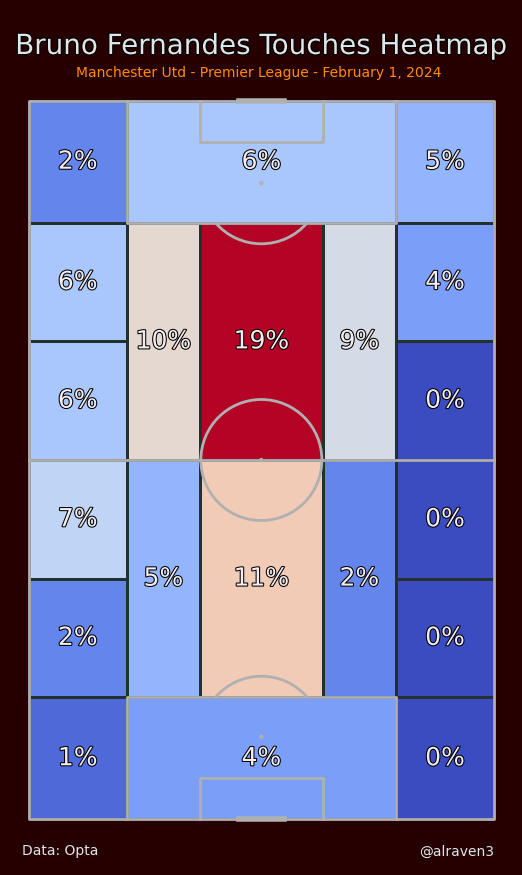

In [72]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#260000')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(player_touches.x, player_touches.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"{player_name} Touches Heatmap", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=20)
fig.text(0.15, 0.9, f"{player_team} - {competition_date}",color='darkorange')


Text(0.15, 0.87, 'Manchester Utd Premier League - February 1, 2024')

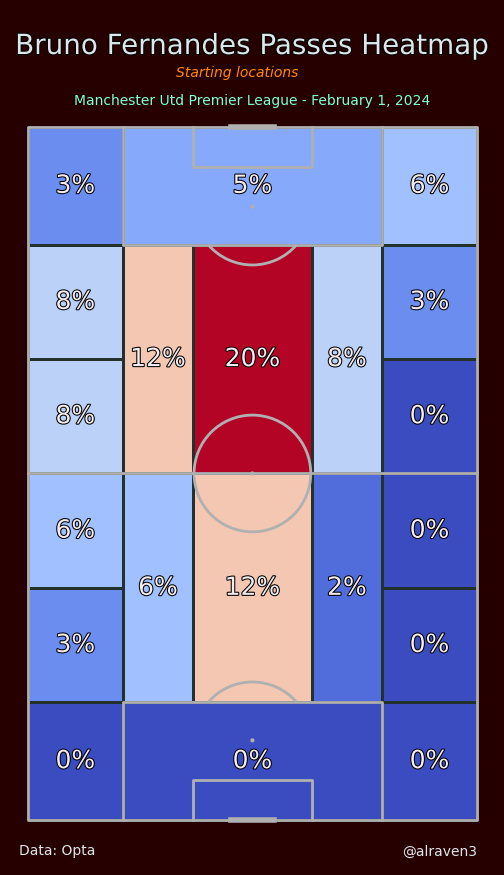

In [73]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000',pad_top=10)
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#260000')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(player_passes.x, player_passes.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"{player_name} Passes Heatmap", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=20)
fig.text(0.35, 0.9, "Starting locations",color='darkorange',style='italic')
fig.text(0.15, 0.87, f"{player_team} {competition_date}",color='aquamarine')

Text(0.15, 0.9, 'Manchester Utd - Premier League - February 1, 2024')

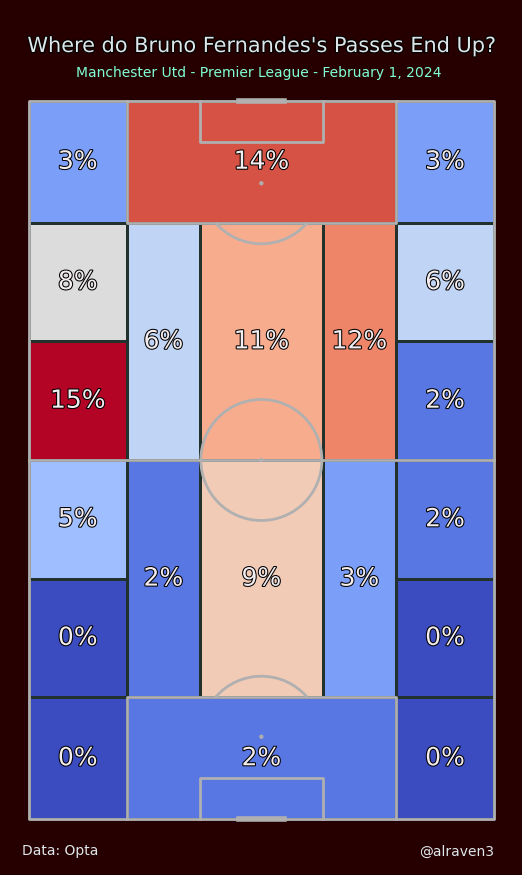

In [74]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#260000')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#260000')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(player_passes.endX, player_passes.endY, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"Where do {player_name}'s Passes End Up?", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=15)
fig.text(0.15, 0.9, f"{player_team} - {competition_date}",color='aquamarine')

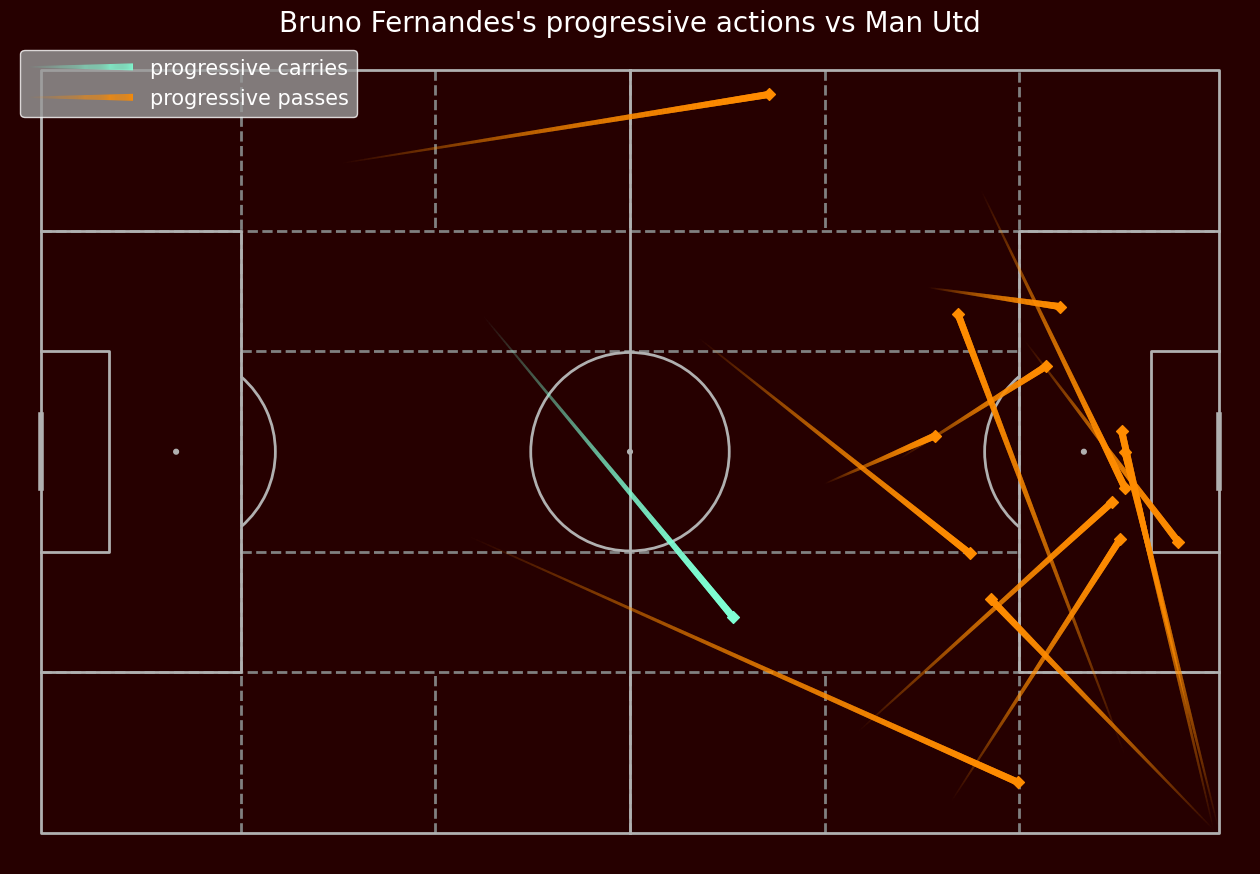

In [75]:
#player_name = 'Giorgio Scalvini'
player_passes = df_passes[df_passes['name']==player_name]
player_prog_passes = player_passes[player_passes['progressive']==True]
player_prog_carries = player_carries[player_carries['progressive']==True]
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', positional_linestyle='--', pitch_color='#260000')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#260000')
pitch.scatter(player_prog_carries.end_x, player_prog_carries.end_y,color='aquamarine',marker='D',ax=ax)
pitch.lines(player_prog_carries.start_x, player_prog_carries.start_y,
             player_prog_carries.end_x, player_prog_carries.end_y,
             comet=True, transparent=True,color='aquamarine',label='progressive carries',ax=ax)
pitch.scatter(player_prog_passes.endX, player_prog_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(player_prog_passes.x, player_prog_passes.y,
             player_prog_passes.endX, player_prog_passes.endY,
             comet=True, transparent=True,label='progressive passes',color='darkorange', ax=ax)
ax_title = ax.set_title(f'{player_name}\'s progressive actions vs {a_team}', fontsize=20,color='white')
ax.legend(facecolor='#999999', edgecolor='white',labelcolor='white',fontsize=15,loc='upper left', handlelength=5)